In [1]:
#author： 11911419 骆家睿
#author： 11911424 张习之
#分工：task2是骆家睿和张习之所写
# task3是两人共同所写的聚类分析
#task4是骆家睿所做的回归分析
#task5骆家睿和张习之做的补充
#
#Background introduction
#因为几年来房价上涨，升起了购房热潮，于是便有了探究房价和其他因素的关系。
#在给出的数据中，有房价和犯罪类型，犯罪手段，地理信息等。。。。。。
#基于目前给出的两个数据集（犯罪信息和地理信息和房价相关信息），
#我组根据可视化和聚类先探究数据之间的关系，最后根据相应的地理信息特征，犯罪信息等特征进行模型的搭建。
#最后经过多次的改进和尝试使得回归效果中的r2_score能达到0.95左右，而且不过拟合，预测效果不错。
#

In [2]:
###Task2###
#这里是将对数据先进行粗略的预处理，并且将数据进行熟悉探索可视化出来，并得出相应的结论。
#最后为Task3和Task4做基础，再进一步对数据进行研究

In [3]:
import  pandas as pd
import  numpy as np
import sklearn
import  seaborn as sns
import matplotlib.pyplot as plt

In [4]:

# 首先将冗余的数据直接drop掉。冗余的数据是直接用datagrip 将数据select 出来观察得到
raw_data=pd.read_csv("DC_Crime.csv")
raw_data=pd.DataFrame(raw_data)
raw_data.dropna(axis=0,how='any',subset=['WARD','START_DATE','DISTRICT','sector','PSA','BLOCK','VOTING_PRECINCT'],inplace=True)
raw_data.reset_index(inplace=True,drop=True)
# print(raw_data.loc[:,"BID"])
# print(raw_data.loc[:,"CENSUS_TRACT"])
# print(raw_data.loc[:,"ucr-rank"])
m=raw_data.isnull().sum(axis=0)
print(m)
print(raw_data.shape[1])

NEIGHBORHOOD_CLUSTER      5496
CENSUS_TRACT              1191
offensegroup                 0
LONGITUDE                    0
END_DATE                 26766
offense-text                 0
SHIFT                        0
YBLOCK                       0
DISTRICT                     0
WARD                         0
YEAR                         0
offensekey                   0
BID                     374238
sector                       0
PSA                          0
ucr-rank                     0
BLOCK_GROUP               1191
VOTING_PRECINCT              0
XBLOCK                       0
BLOCK                        0
START_DATE                   0
CCN                          0
OFFENSE                      0
OCTO_RECORD_ID               0
ANC                          0
REPORT_DAT                   0
METHOD                       0
location                     0
LATITUDE                     0
dtype: int64
29


In [5]:
#去除重复且啰嗦的数据列
raw_data=pd.DataFrame(raw_data.loc[:,['METHOD','OFFENSE','NEIGHBORHOOD_CLUSTER','CENSUS_TRACT','XBLOCK','BLOCK','YBLOCK','DISTRICT','WARD','sector','PSA','LONGITUDE','LATITUDE','VOTING_PRECINCT','CCN','OCTO_RECORD_ID','ANC','BLOCK_GROUP','YEAR','START_DATE','SHIFT','REPORT_DAT']])
#目前缺失值的情况
m=raw_data.isnull().sum(axis=0)
print(m)
print(len(m))
print(raw_data.shape[0])

METHOD                     0
OFFENSE                    0
NEIGHBORHOOD_CLUSTER    5496
CENSUS_TRACT            1191
XBLOCK                     0
BLOCK                      0
YBLOCK                     0
DISTRICT                   0
WARD                       0
sector                     0
PSA                        0
LONGITUDE                  0
LATITUDE                   0
VOTING_PRECINCT            0
CCN                        0
OCTO_RECORD_ID             0
ANC                        0
BLOCK_GROUP             1191
YEAR                       0
START_DATE                 0
SHIFT                      0
REPORT_DAT                 0
dtype: int64
22
448866


In [6]:
#去除START_DATE ,end_time 小于2008年的数据。因为发现2008年之前的数据有异常
for i in range(raw_data.shape[0]):
    if int(raw_data.loc[i,'START_DATE'][0:4])<2008:
        raw_data.drop(index=i,inplace=True)

raw_data.reset_index(inplace=True,drop=True)
print(raw_data.shape[0])
raw_data.to_csv(r'raw_data_crime.csv',index = None)

448418


In [7]:
#Data exploration: data statistics and data visualization;
#观察每年中 各个offense的发生次数
dectect_year_offence=raw_data[['YEAR','OFFENSE']]
#dectect_year_offence=pd.DataFrame(raw_data.groupby(['YEAR'])['OFFENSE'].value_counts())

dectect_year_offence=pd.DataFrame(dectect_year_offence.groupby(['YEAR'],as_index=False).size())
print(dectect_year_offence)
shift_offense=raw_data.groupby(['SHIFT'],as_index=False).count()
shift_offense

    YEAR   size
0   2008  33958
1   2009  31223
2   2010  31635
3   2011  33255
4   2012  35273
5   2013  35853
6   2014  38399
7   2015  37248
8   2016  37203
9   2017  33107
10  2018  33749
11  2019  33906
12  2020  27866
13  2021   5743


,SHIFT,METHOD,OFFENSE,NEIGHBORHOOD_CLUSTER,CENSUS_TRACT,XBLOCK,BLOCK,YBLOCK,DISTRICT,WARD,...,LONGITUDE,LATITUDE,VOTING_PRECINCT,CCN,OCTO_RECORD_ID,ANC,BLOCK_GROUP,YEAR,START_DATE,REPORT_DAT
0,day,169329,169329,167280,168927,169329,169329,169329,169329,169329,...,169329,169329,169329,169329,169329,169329,168927,169329,169329,169329
1,evening,191672,191672,189319,191198,191672,191672,191672,191672,191672,...,191672,191672,191672,191672,191672,191672,191198,191672,191672,191672
2,midnight,87417,87417,86337,87102,87417,87417,87417,87417,87417,...,87417,87417,87417,87417,87417,87417,87102,87417,87417,87417


over


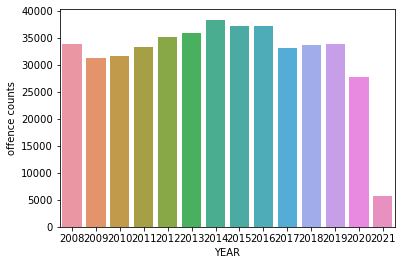

In [8]:
#将每年中 各个offense的发生次数 可视化，每年的犯罪数量几乎不变，除了2021年
ab=sns.barplot(x='YEAR',y='size',data=dectect_year_offence)
print("over")
plt.xlabel("YEAR")
plt.ylabel("offence counts")
plt.show()

In [9]:
#观察每个月中offence发生的次数
dectect_shift_offence=raw_data[['SHIFT','OFFENSE']]
dectect_shift_offence=pd.DataFrame(raw_data.groupby(['SHIFT'],as_index=False)['OFFENSE'].size())
print(dectect_shift_offence)

      SHIFT    size
0       day  169329
1   evening  191672
2  midnight   87417


over


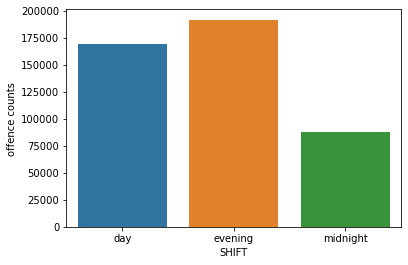

In [10]:
#观察每个时间段发生的次数，在midnight时offence的次数相对较少一些
ab=sns.barplot(x='SHIFT',y='size',data=dectect_shift_offence)
print("over")
plt.xlabel("SHIFT")
plt.ylabel("offence counts")
plt.show()

In [11]:
#观察每个月发生的次数
dectect_month_offence=pd.DataFrame(raw_data[['REPORT_DAT','OFFENSE']])
dectect_month_offence['REPORT_DAT']=dectect_month_offence['REPORT_DAT'].str[5:7]
dectect_month_offence=pd.DataFrame(dectect_month_offence.groupby(['REPORT_DAT'],as_index=False)['OFFENSE'].size())
print(dectect_month_offence)

   REPORT_DAT   size
0          01  36963
1          02  30739
2          03  33976
3          04  33319
4          05  38018
5          06  38991
6          07  40640
7          08  40831
8          09  39675
9          10  41301
10         11  37192
11         12  36773


In [12]:
#观察每个月中offence发生的次数
dectect_shift_offence=raw_data[['SHIFT','OFFENSE']]
dectect_shift_offence=pd.DataFrame(raw_data.groupby(['SHIFT'],as_index=False)['OFFENSE'].size())
print(dectect_shift_offence)

      SHIFT    size
0       day  169329
1   evening  191672
2  midnight   87417


over


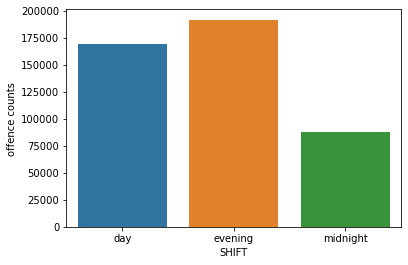

In [13]:
#观察每个时间段发生的次数
ab=sns.barplot(x='SHIFT',y='size',data=dectect_shift_offence)
print("over")
plt.xlabel("SHIFT")
plt.ylabel("offence counts")
plt.show()


   REPORT_DAT   size
0          01  36963
1          02  30739
2          03  33976
3          04  33319
4          05  38018
5          06  38991
6          07  40640
7          08  40831
8          09  39675
9          10  41301
10         11  37192
11         12  36773
over


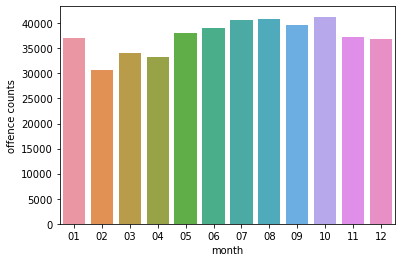

In [14]:
#观察每个月发生的次数
dectect_month_offence=pd.DataFrame(raw_data[['REPORT_DAT','OFFENSE']])
dectect_month_offence['REPORT_DAT']=dectect_month_offence['REPORT_DAT'].str[5:7]
dectect_month_offence=pd.DataFrame(dectect_month_offence.groupby(['REPORT_DAT'],as_index=False)['OFFENSE'].size())
print(dectect_month_offence)
#每个月发生的次数进行可视化
ab=sns.barplot(x='REPORT_DAT',y='size',data=dectect_month_offence)
print("over")
plt.xlabel("month")
plt.ylabel("offence counts")
plt.show()

In [15]:
# offence 和method  的关系
dectect_offence_method=pd.DataFrame(raw_data[['OFFENSE','METHOD']])
dectect_offence_method=pd.DataFrame(dectect_offence_method.groupby(['OFFENSE','METHOD'],as_index=False).size())
print(dectect_offence_method)

                       OFFENSE  METHOD    size
0                        arson     gun       1
1                        arson   knife       1
2                        arson  others     353
3   assault w/dangerous weapon     gun    8983
4   assault w/dangerous weapon   knife   10411
5   assault w/dangerous weapon  others    9461
6                     burglary     gun     319
7                     burglary   knife     119
8                     burglary  others   35419
9                     homicide     gun    1372
10                    homicide   knife     196
11                    homicide  others     228
12         motor vehicle theft     gun      14
13         motor vehicle theft   knife       6
14         motor vehicle theft  others   42043
15                     robbery     gun   15979
16                     robbery   knife    2450
17                     robbery  others   23736
18                   sex abuse     gun     175
19                   sex abuse   knife     200
20           

over


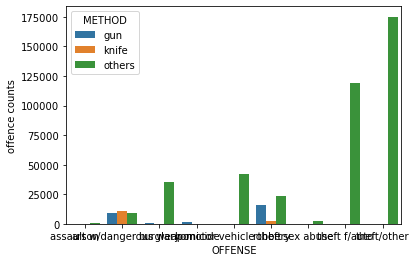

In [16]:
#可视化 offence 和method  的关系
ab=sns.barplot(x='OFFENSE',y='size',hue='METHOD',data=dectect_offence_method)
print("over")
plt.xlabel("OFFENSE")
plt.ylabel("offence counts")
plt.show()

    WARD                     OFFENSE  size
0    1.0                       arson     9
1    1.0  assault w/dangerous weapon   483
2    1.0                    burglary  1377
3    1.0         motor vehicle theft  1570
4    1.0                     robbery  1164
..   ...                         ...   ...
58   8.0         motor vehicle theft  3468
59   8.0                     robbery  1689
60   8.0                   sex abuse   162
61   8.0                theft f/auto  4073
62   8.0                 theft/other  4874

[63 rows x 3 columns]
over


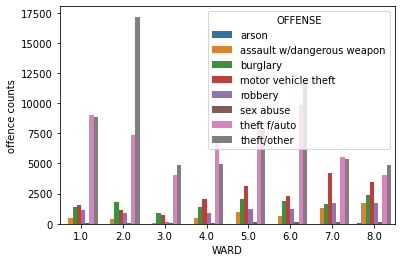

In [17]:
#  offense 类型随时间和地点的变化图
dectect_offence_shift_ward=pd.DataFrame(raw_data[['OFFENSE','SHIFT','WARD']])

#day 时间的ward 和offense 类型犯罪的数量统计
dectect_offence_shift_ward.drop(index=dectect_offence_shift_ward[(raw_data.loc[:,'SHIFT']!='day')].index,inplace=True)
dectect_offence_shift_ward.reset_index(inplace=True,drop=True)

dectect_offence_shift_ward=pd.DataFrame(dectect_offence_shift_ward[['OFFENSE','WARD']])
dectect_offence_shift_ward=pd.DataFrame(dectect_offence_shift_ward.groupby(['WARD','OFFENSE'],as_index=False).size())


print(dectect_offence_shift_ward)

#不同的ward不同offense的犯罪数量的观察

ab=sns.barplot(x='WARD',y='size',hue='OFFENSE',data=dectect_offence_shift_ward)
print("over")
plt.xlabel("WARD")
plt.ylabel("offence counts")
plt.show()

       SHIFT  WARD   size
0        day   1.0  22560
1        day   2.0  28943
2        day   3.0  10812
3        day   4.0  16813
4        day   5.0  23883
5        day   6.0  27925
6        day   7.0  19910
7        day   8.0  18483
8    evening   1.0  26702
9    evening   2.0  38357
10   evening   3.0  11422
11   evening   4.0  16901
12   evening   5.0  24395
13   evening   6.0  30360
14   evening   7.0  23174
15   evening   8.0  20361
16  midnight   1.0  14159
17  midnight   2.0  14417
18  midnight   3.0   2186
19  midnight   4.0   7087
20  midnight   5.0  12791
21  midnight   6.0  12411
22  midnight   7.0  12398
23  midnight   8.0  11968
object
   SHIFT  WARD   size
0      0   1.0  22560
1      0   2.0  28943
2      0   3.0  10812
3      0   4.0  16813
4      0   5.0  23883
5      0   6.0  27925
6      0   7.0  19910
7      0   8.0  18483
8      1   1.0  26702
9      1   2.0  38357
10     1   3.0  11422
11     1   4.0  16901
12     1   5.0  24395
13     1   6.0  30360
14     1   7.

<AxesSubplot:xlabel='WARD', ylabel='SHIFT'>

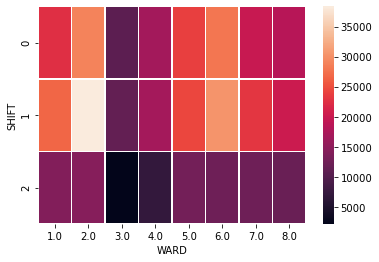

In [18]:
#热力图作品,对于shift 和ward 的offense的犯罪数量的变化
import  pandas as pd
data_shift_ward_count=pd.DataFrame(raw_data[['SHIFT','WARD','OFFENSE']])

# print(data_shift_ward_count)

data_shift_ward_count=pd.DataFrame(data_shift_ward_count.groupby(['SHIFT','WARD'],as_index=False)['OFFENSE'].size())
print(data_shift_ward_count)
print(data_shift_ward_count['SHIFT'].dtype)

for i in range(data_shift_ward_count.shape[0]):
    if data_shift_ward_count.loc[i,'SHIFT']=='day':
        data_shift_ward_count.loc[i,'SHIFT']=0
    if data_shift_ward_count.loc[i,'SHIFT']=='evening':
        data_shift_ward_count.loc[i,'SHIFT']=1
    if data_shift_ward_count.loc[i,'SHIFT']=='midnight':
        data_shift_ward_count.loc[i,'SHIFT']=2

        
        
print(data_shift_ward_count)
data_shift_ward_count['SHIFT']=data_shift_ward_count['SHIFT'].astype(int)
print(data_shift_ward_count['SHIFT'].dtype)

data_shift_ward_count=data_shift_ward_count.pivot('SHIFT','WARD','size')
print (data_shift_ward_count)
sns.heatmap(data_shift_ward_count,linewidths=0.5)
#如果根据ward分类，发现day 和evening的时候发生的犯罪数量更多

       SHIFT  DISTRICT   size
0        day       1.0  25137
1        day       2.0  31209
2        day       3.0  29534
3        day       4.0  23112
4        day       5.0  22727
5        day       6.0  21628
6        day       7.0  15982
7    evening       1.0  28805
8    evening       2.0  38367
9    evening       3.0  34295
10   evening       4.0  24139
11   evening       5.0  23435
12   evening       6.0  24652
13   evening       7.0  17979
14  midnight       1.0  11088
15  midnight       2.0  11321
16  midnight       3.0  17721
17  midnight       4.0  10492
18  midnight       5.0  12983
19  midnight       6.0  13145
20  midnight       7.0  10667
object
int32
DISTRICT    1.0    2.0    3.0    4.0    5.0    6.0    7.0
SHIFT                                                    
0         25137  31209  29534  23112  22727  21628  15982
1         28805  38367  34295  24139  23435  24652  17979
2         11088  11321  17721  10492  12983  13145  10667


<AxesSubplot:xlabel='DISTRICT', ylabel='SHIFT'>

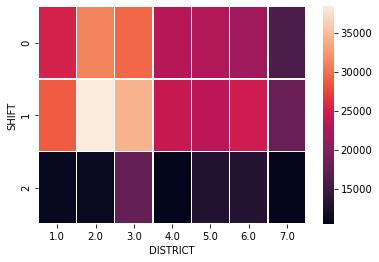

In [19]:
data_shift_district_count=pd.DataFrame(raw_data[['SHIFT','DISTRICT','OFFENSE']])



# print(data_shift_ward_count)

data_shift_district_count=pd.DataFrame(data_shift_district_count.groupby(['SHIFT','DISTRICT'],as_index=False)['OFFENSE'].size())
print(data_shift_district_count)
print(data_shift_district_count['SHIFT'].dtype)

for i in range(data_shift_district_count.shape[0]):
    if data_shift_district_count.loc[i,'SHIFT']=='day':
        data_shift_district_count.loc[i,'SHIFT']=0
    if data_shift_district_count.loc[i,'SHIFT']=='evening':
        data_shift_district_count.loc[i,'SHIFT']=1
    if data_shift_district_count.loc[i,'SHIFT']=='midnight':
        data_shift_district_count.loc[i,'SHIFT']=2

        
data_shift_district_count['SHIFT']=data_shift_district_count['SHIFT'].astype(int)
print(data_shift_district_count['SHIFT'].dtype)

data_shift_district_count=data_shift_district_count.pivot('SHIFT','DISTRICT','size')
print (data_shift_district_count)
sns.heatmap(data_shift_district_count,linewidths=0.5)
#根据district 进行分类，发现也是day 和evening的 犯罪数量最多

       SHIFT sector   size
0        day    1D1   7200
1        day    1D2  11327
2        day    1D3   6345
3        day    2D1   7031
4        day    2D2   9146
..       ...    ...    ...
58  midnight    6D2   3490
59  midnight    6D3   4639
60  midnight    7D1   3809
61  midnight    7D2   3804
62  midnight    7D3   3096

[63 rows x 3 columns]
object
int32
sector    1D1    1D2   1D3   2D1    2D2    2D3    3D1    3D2    3D3   4D1  \
SHIFT                                                                       
0        7200  11327  6345  7031   9146  15078   9019  10082  10531  8316   
1       10011  11305  7148  8008  11283  19140  11012  11986  11435  8670   
2        4337   3979  2533  1353   2300   7699   4510   7282   6020  3664   

sector  ...   4D3   5D1   5D2   5D3   6D1   6D2   6D3   7D1   7D2   7D3  
SHIFT   ...                                                              
0       ...  7373  6437  9432  6903  7833  7063  6745  5673  5800  4571  
1       ...  8065  7001  8643  7

<AxesSubplot:xlabel='sector', ylabel='SHIFT'>

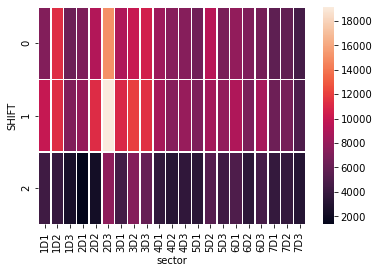

In [20]:
#绘出sector不同时和犯罪数量的热力图
data_shift_sector_count=pd.DataFrame(raw_data[['SHIFT','sector','OFFENSE']])
# print(data_shift_ward_count)

data_shift_sector_count=pd.DataFrame(data_shift_sector_count.groupby(['SHIFT','sector'],as_index=False)['OFFENSE'].size())
print(data_shift_sector_count)
print(data_shift_sector_count['SHIFT'].dtype)

for i in range(data_shift_sector_count.shape[0]):
    if data_shift_sector_count.loc[i,'SHIFT']=='day':
        data_shift_sector_count.loc[i,'SHIFT']=0
    if data_shift_sector_count.loc[i,'SHIFT']=='evening':
        data_shift_sector_count.loc[i,'SHIFT']=1
    if data_shift_sector_count.loc[i,'SHIFT']=='midnight':
        data_shift_sector_count.loc[i,'SHIFT']=2

data_shift_sector_count['SHIFT']=data_shift_sector_count['SHIFT'].astype(int)
print(data_shift_sector_count['SHIFT'].dtype)

data_shift_sector_count=data_shift_sector_count.pivot('SHIFT','sector','size')
print (data_shift_sector_count)
sns.heatmap(data_shift_sector_count,linewidths=0.5)

WARD   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0
YEAR                                                
2008  4896  6244  1854  2982  4058  5136  4358  4430
2009  4425  5828  1958  2855  3682  4514  3744  4217
2010  4356  5574  1927  3095  3969  4234  4006  4474
2011  4879  6159  1923  2908  4279  4771  4023  4313
2012  4997  6549  1788  2990  4772  5476  4335  4366
2013  5406  5958  1950  3267  4601  5625  4612  4434
2014  5406  6773  1831  3811  5398  5995  5101  4084
2015  5251  6780  1914  3540  5202  6067  4458  4036
2016  5445  7305  1795  3192  4908  6401  4273  3884
2017  4630  5969  1575  2887  4807  5510  4310  3419
2018  4629  6254  1935  3107  5008  5622  4075  3119
2019  4728  7115  1957  2894  5081  5639  3736  2756
2020  3529  4360  1702  2700  4374  4747  3716  2738
2021   844   849   311   573   930   959   735   542


<AxesSubplot:xlabel='WARD', ylabel='YEAR'>

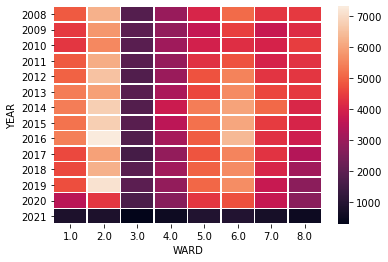

In [21]:
#根据时间绘画出ward 和year的热力图。
data_year_ward_count=pd.DataFrame(raw_data[['YEAR','WARD','OFFENSE']])
data_year_ward_count=pd.DataFrame(data_year_ward_count.groupby(['YEAR','WARD'],as_index=False)['OFFENSE'].size())
data_year_ward_count['YEAR']=data_year_ward_count['YEAR'].astype(int)

data_year_ward_count=data_year_ward_count.pivot('YEAR','WARD','size')
print (data_year_ward_count)
sns.heatmap(data_year_ward_count,linewidths=0.5)

   REPORT_DAT  WARD  size
0          01   1.0  5032
1          01   2.0  6858
2          01   3.0  2039
3          01   4.0  3456
4          01   5.0  5177
..        ...   ...   ...
91         12   4.0  3343
92         12   5.0  5038
93         12   6.0  5764
94         12   7.0  4667
95         12   8.0  4181

[96 rows x 3 columns]
WARD         1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0
REPORT_DAT                                                
1           5032  6858  2039  3456  5177  5692  4583  4126
2           4396  5886  1868  2854  4098  4600  3666  3371
3           4896  6552  1971  2968  4705  4994  4096  3794
4           4703  5966  1840  3133  4680  4938  4099  3960
5           5399  6667  2104  3606  5144  5711  4876  4511
6           5666  6991  2214  3494  5101  6345  4826  4354
7           5764  7172  2082  3626  5545  6742  5109  4600
8           5609  7436  2111  3702  5598  6726  5010  4639
9           5598  7045  2078  3616  5469  6585  4886  4398
10          5904

<AxesSubplot:xlabel='WARD', ylabel='REPORT_DAT'>

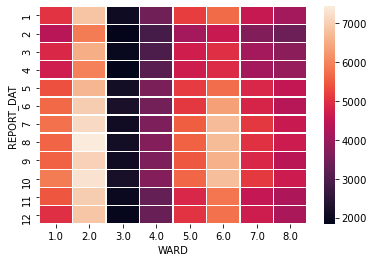

In [22]:
#month 案件报道时间的热力图关系绘制
data_month_ward_count=pd.DataFrame(raw_data[['REPORT_DAT','WARD','OFFENSE']])
data_month_ward_count['REPORT_DAT']=data_month_ward_count['REPORT_DAT'].str[5:7]


data_month_ward_count=pd.DataFrame(data_month_ward_count.groupby(['REPORT_DAT','WARD'],as_index=False)['OFFENSE'].size())
print(data_month_ward_count)

data_month_ward_count['REPORT_DAT']=data_month_ward_count['REPORT_DAT'].astype(int)

data_month_ward_count=data_month_ward_count.pivot('REPORT_DAT','WARD','size')
print (data_month_ward_count)
sns.heatmap(data_month_ward_count,linewidths=0.5)

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
raw_data2=pd.read_csv("DC_Crime.csv")
#在这个部分，我们用柱状图和散点图将地理信息可视化
#首先我们将数据导入数据库当中，便于用SQL处理数据

In [24]:
#district_vs_numberOfCase.csv由SQL产生，SQL语句如下
#with aa as(
#select dis,count(property) ac from (select district dis,offensegroup property from "DC_Crime" where offensegroup='property') as gg group by dis)
#select aa.dis district,aa.ac property,bb.bc violent from aa inner join
#    (select dis,count(property) bc from (select district dis,offensegroup property from "DC_Crime" where offensegroup='violent') as gg group by dis) as bb on aa.dis=bb.dis;
#
district_numOfCase=pd.read_csv("district_vs_numberOfCase.csv")

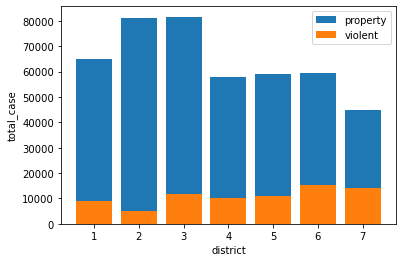

In [25]:
#visualization of 
%matplotlib inline
district=district_numOfCase["district"]
pro=district_numOfCase["property"]
violent=district_numOfCase["violent"]
import matplotlib.pyplot as plt
plt.bar(x=district,height=pro,bottom=violent,label='property')
plt.bar(x=district,height=violent,bottom=0,label='violent')
plt.legend()
plt.xlabel('district')
plt.ylabel('total_case')
plt.show()

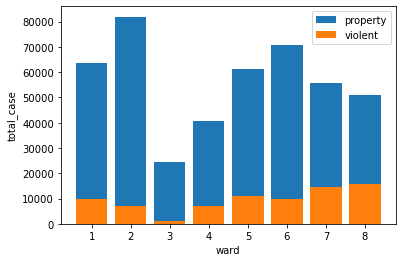

In [26]:
#ward_vs_numOfCase.csv由SQL生成，SQL语句如下
#with aa as(
#select dis,count(property) ac from (select ward dis,offensegroup property from "DC_Crime" where offensegroup='property') as gg group by dis)
#select aa.dis ward,aa.ac property,bb.bc violent from aa inner join
#    (select dis,count(property) bc from (select ward dis,offensegroup property from "DC_Crime" where offensegroup='violent') as gg group by dis) as bb on aa.dis=bb.dis;
#
ward_numOfCase=pd.read_csv("ward_vs_numOfCase.csv")
ward=ward_numOfCase["ward"]
pro=ward_numOfCase["property"]
violent=ward_numOfCase["violent"]
plt.bar(x=ward,height=pro,bottom=violent,label='property')
plt.bar(x=ward,height=violent,bottom=0,label='violent')
plt.legend()
plt.xlabel('ward')
plt.ylabel('total_case')
plt.show()

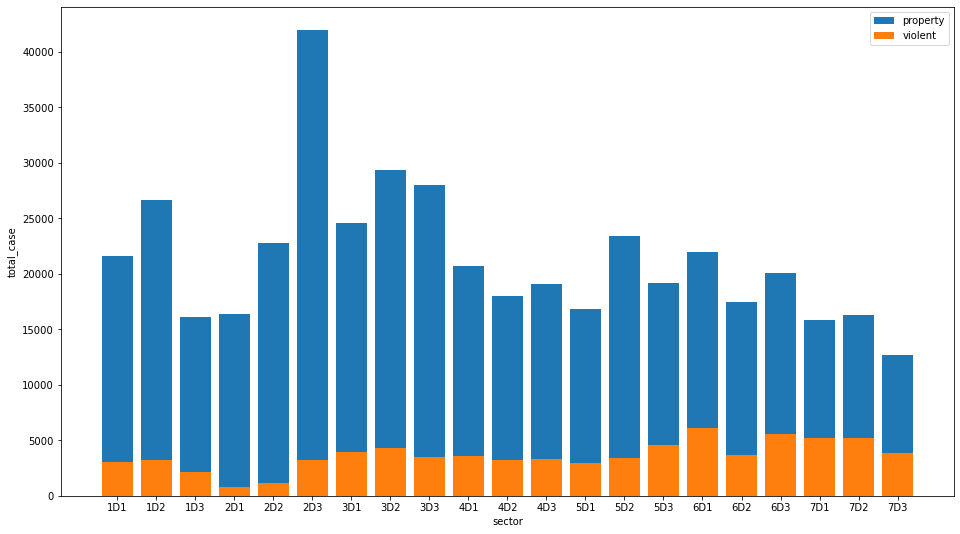

In [27]:
#sector_vs_numOfcase.csv由SQL语句生成，SQL语句如下
#with aa as(
#select dis,count(property) ac from (select sector dis,offensegroup property from "DC_Crime" where offensegroup='property') as gg group by dis)
#select aa.dis sector,aa.ac property,bb.bc violent from aa inner join
#    (select dis,count(property) bc from (select sector dis,offensegroup property from "DC_Crime" where offensegroup='violent') as gg group by dis) as bb on aa.dis=bb.dis;
#
sector_numofcase=pd.read_csv("sector_vs_numofcase.csv")
sector=sector_numofcase["sector"]
pro=sector_numofcase["property"]
violent=sector_numofcase["violent"]
plt.figure(figsize=(16,9))
plt.bar(x=sector,height=pro,bottom=violent,label='property')
plt.bar(x=sector,height=violent,bottom=0,label='violent')
plt.legend()
plt.xlabel('sector')
plt.ylabel('total_case')
plt.show()

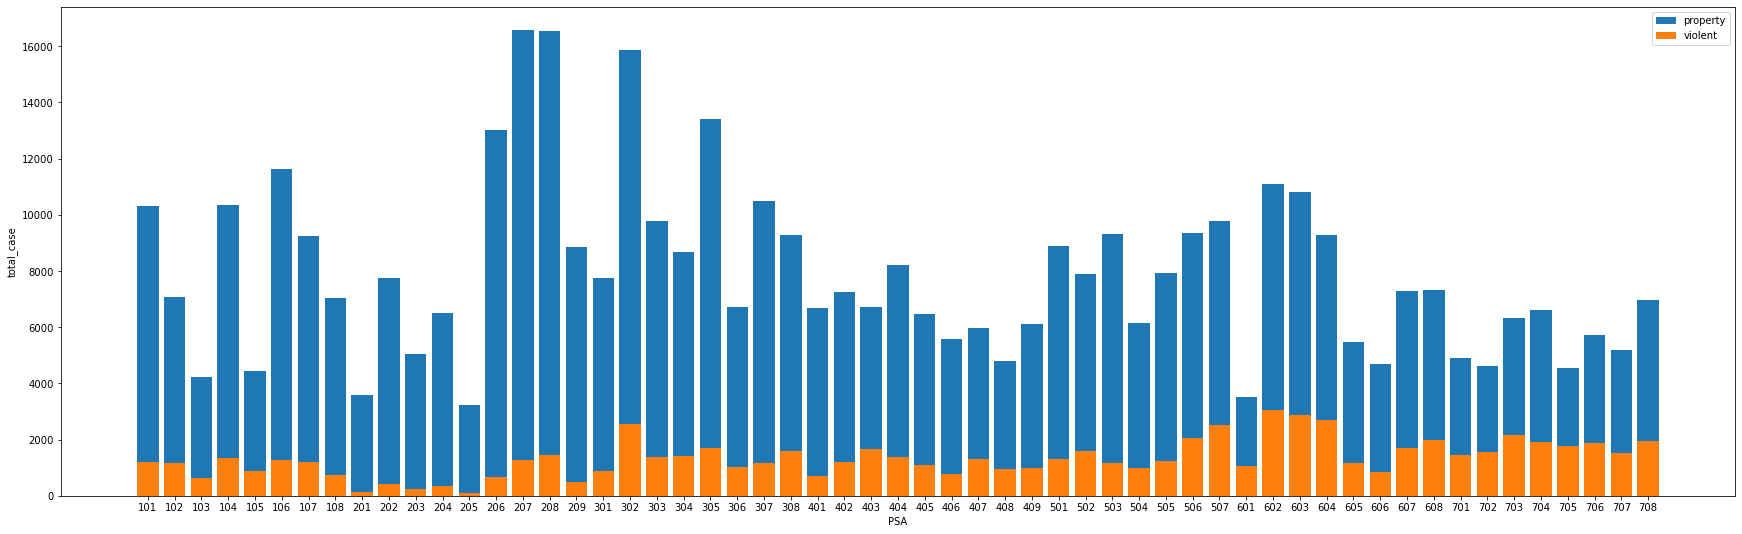

In [28]:
#psa_vs_numofcase.csv由SQL生成，SQL语句如下
#with aa as(
#select dis,count(property) ac from (select psa dis,offensegroup property from "DC_Crime" where offensegroup='property') as gg group by dis)
#select aa.dis psa,aa.ac property,bb.bc violent from aa inner join
#    (select dis,count(property) bc from (select psa dis,offensegroup property from "DC_Crime" where offensegroup='violent') as gg group by dis) as bb on aa.dis=bb.dis;
#
psa_numofcase=pd.read_csv("psa_vs_numofcase.csv")
psa=psa_numofcase["psa"].astype('str')
pro=psa_numofcase["property"]
violent=psa_numofcase["violent"]
plt.figure(figsize=(30,9))
plt.bar(x=psa,height=pro,bottom=violent,label='property')
plt.bar(x=psa,height=violent,bottom=0,label='violent')
plt.legend()
plt.xlabel('PSA')
plt.ylabel('total_case')
plt.show()

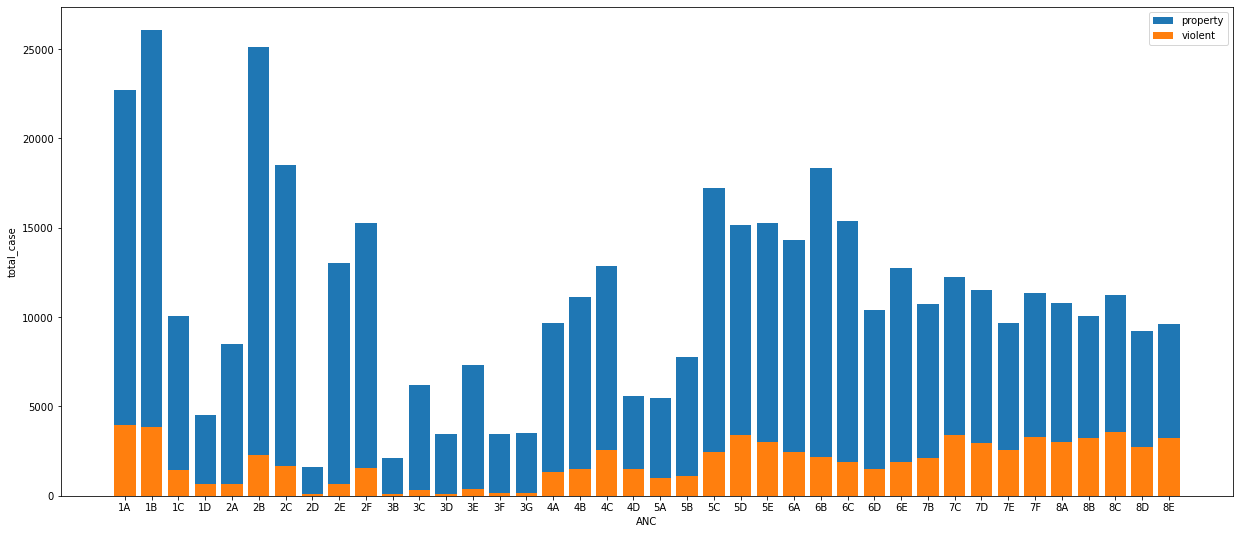

In [29]:
#anc_vs_numofcase.csv由SQL语句生成，SQL语句如下
#with aa as(
#select dis,count(property) ac from (select anc dis,offensegroup property from "DC_Crime" where offensegroup='property') as gg group by dis)
#select aa.dis anc,aa.ac property,bb.bc violent from aa inner join
#    (select dis,count(property) bc from (select anc dis,offensegroup property from "DC_Crime" where offensegroup='violent') as gg group by dis) as bb on aa.dis=bb.dis;
#
anc_numofcase=pd.read_csv("anc_vs_numofcase.csv")
anc=anc_numofcase["anc"]
pro=anc_numofcase["property"]
violent=anc_numofcase["violent"]
plt.figure(figsize=(21,9))
plt.bar(x=anc,height=pro,bottom=violent,label='property')
plt.bar(x=anc,height=violent,bottom=0,label='violent')
plt.legend()
plt.xlabel('ANC')
plt.ylabel('total_case')
plt.show()

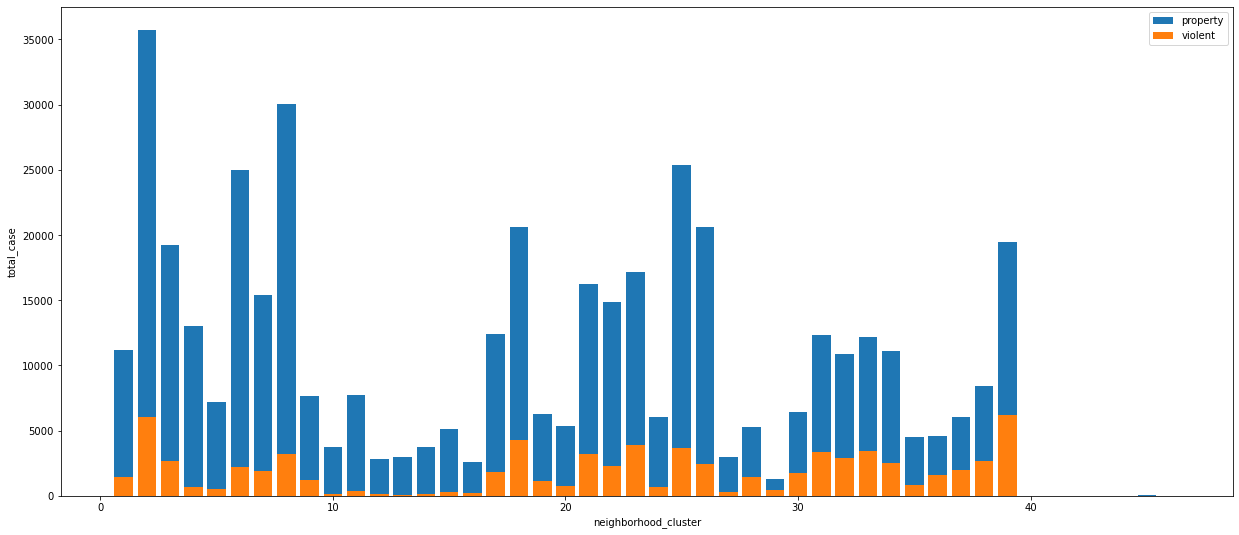

In [30]:
#neigh_vs_numofcase.csv由SQL生成，SQL语句如下
#with aa as(
#select dis,count(property) ac from (select neighborhood_cluster dis,offensegroup property from "DC_Crime" where offensegroup='property') as gg group by dis)
#select substr(aa.dis,9) neigh,aa.ac property,bb.bc violent from aa inner join
#    (select dis,count(property) bc from (select neighborhood_cluster dis,offensegroup property from "DC_Crime" where offensegroup='violent') as gg group by dis) as bb on aa.dis=bb.dis;
#
neigh_numofcase=pd.read_csv("neigh_vs_numofcase.csv")
neigh=neigh_numofcase["neigh"]
pro=neigh_numofcase["property"]
violent=neigh_numofcase["violent"]
plt.figure(figsize=(21,9))
plt.bar(x=neigh,height=pro,bottom=violent,label='property')
plt.bar(x=neigh,height=violent,bottom=0,label='violent')
plt.legend()
plt.xlabel('neighborhood_cluster')
plt.ylabel('total_case')
plt.show()

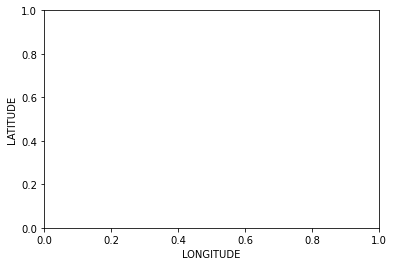

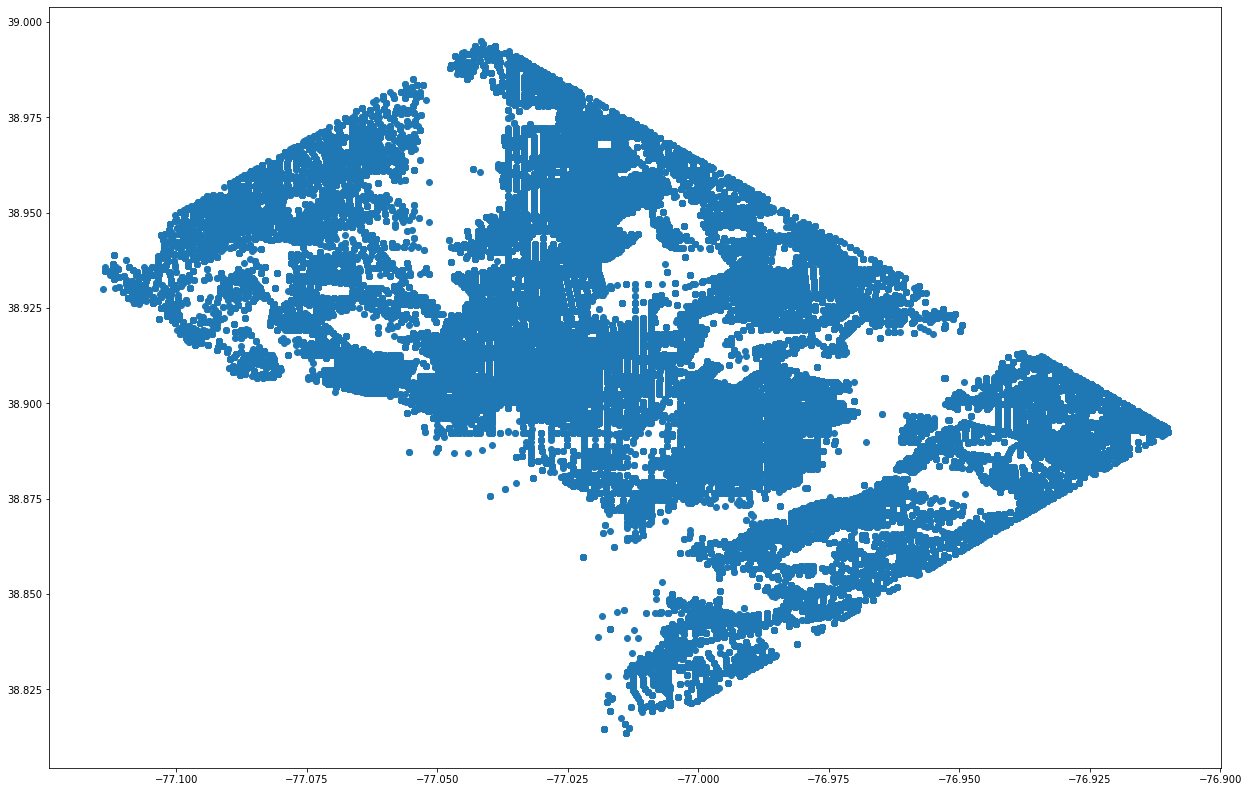

In [31]:
#首先对所有犯罪信息进行可视化，看看分布
#发现犯罪几乎遍布整个华盛顿特区的各个角落，这样的散点图勾勒出整个华盛顿特区区域的轮廓
data1=raw_data2["LONGITUDE"]
data2=raw_data2["LATITUDE"]
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.figure(figsize=(21,14))
plt.scatter(data1,data2)
plt.show()

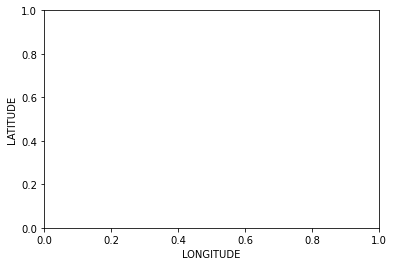

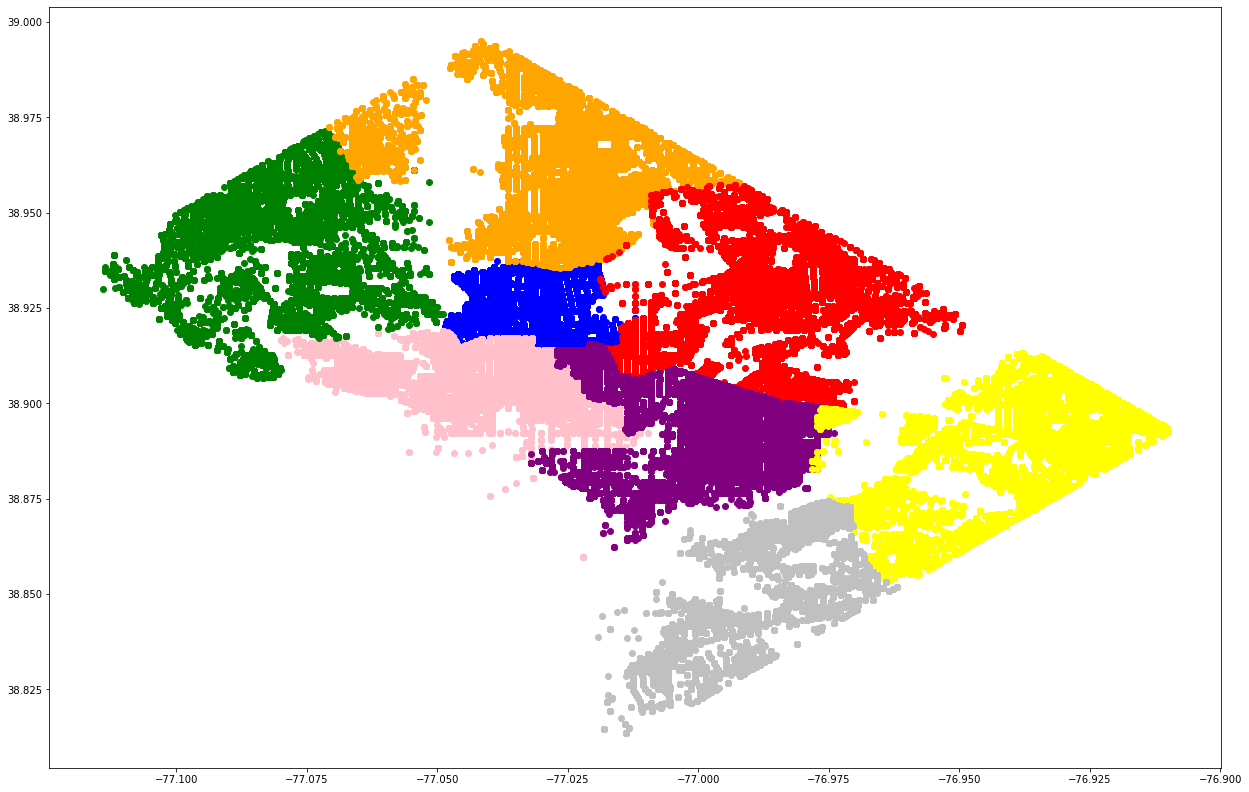

In [32]:
#用不同的颜色标出属于不同ward的犯罪
#可以发现不同ward间界限较为明确，但区域较大，划分过于粗糙
crime_by_ward=pd.DataFrame(raw_data2[['LATITUDE','LONGITUDE','WARD']])
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.figure(figsize=(21,14))
colors=['#0000FF','#FFC0CB','#008000','#FFA500','#FF0000','#800080','#FFFF00','#C0C0C0']
for i in range(1,9):
    crime_ward_i=crime_by_ward[crime_by_ward['WARD']==i]
    data1=crime_ward_i['LONGITUDE']
    data2=crime_ward_i['LATITUDE']
    plt.scatter(data1,data2,c=colors[i-1])
plt.show()

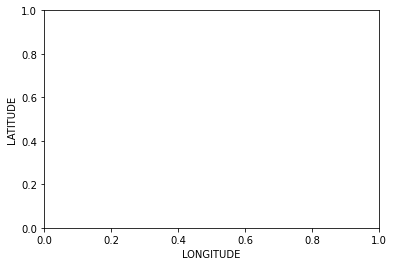

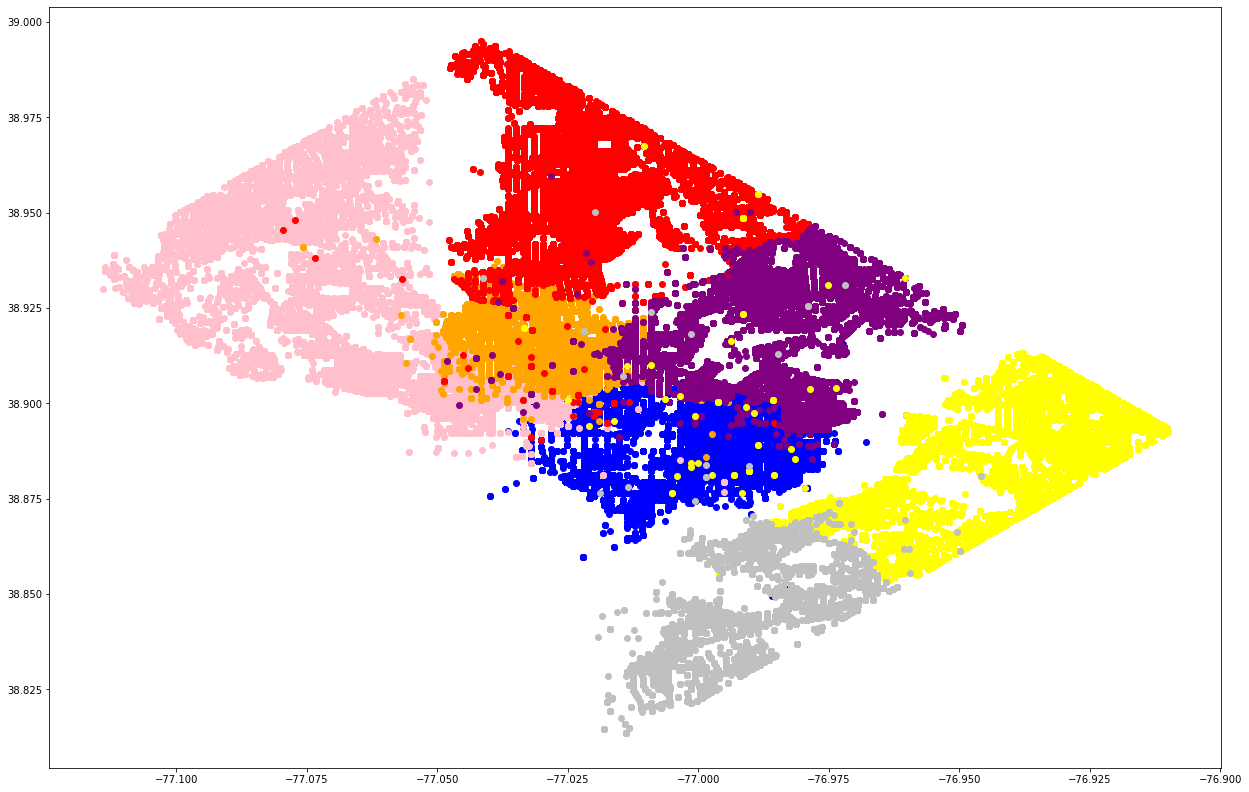

In [33]:
#用不同颜色标出不同district的犯罪
#可以发现district之间界限明确，但区域较大，划分过于粗糙
crime_by_ward=pd.DataFrame(raw_data2[['LATITUDE','LONGITUDE','DISTRICT']])
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.figure(figsize=(21,14))
colors=['#0000FF','#FFC0CB','#FFA500','#FF0000','#800080','#FFFF00','#C0C0C0']
for i in range(1,8):
    crime_ward_i=crime_by_ward[crime_by_ward['DISTRICT']==i]
    data1=crime_ward_i['LONGITUDE']
    data2=crime_ward_i['LATITUDE']
    plt.scatter(data1,data2,c=colors[i-1])
plt.show()

In [34]:
#加载更多更多的颜色，便于后续使用
colors=['#F0F8FF','#FAEBD7','#00FFFF','#7FFFD4','#FFE4C4','#000000','#0000FF','#8A2BE2','#A52A2A',
       '#DEB887','#5F9EA0','#7FFF00','#D2691E','#FF7F50','#6495ED','#FFF8DC','#DC143C','#00FFFF','#00008B','#008B8B','#B8860B','#A9A9A9',
       '#006400','#BDB76B','#8B008B','#556B2F','#FF8C00','#9932CC','#8B0000','#E9967A','#8FBC8F','#483D8B','#2F4F4F','#00CED1','#9400D3',
       '#FF1493','#00BFFF','#696969','#1E90FF','#B22222','#FFFAF0','#228B22','#FF00FF','#DCDCDC','#F8F8FF','#FFD700','#DAA520','#808080',
       '#008000','#ADFF2F','#F0FFF0','#FF69B4','#CD5C5C','#4B0082','#FFFFF0','#F0E68C','#E6E6FA']

In [35]:
#导入PSA的值
distinctPSA=[604,209,305,708,304,205,706,407,607,201,303,701,105,402,406,107,405,605,101,504,102,108,408,608,707,702,207,103,505,502,401,601,206,
            306,704,603,507,606,301,202,308,703,503,208,602,302,409,506,501,403,204,404,705,104,106,307,203]


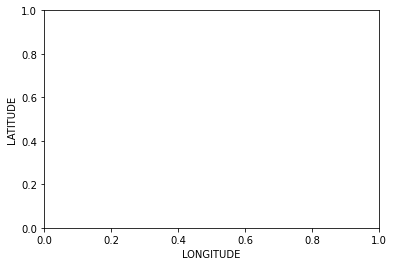

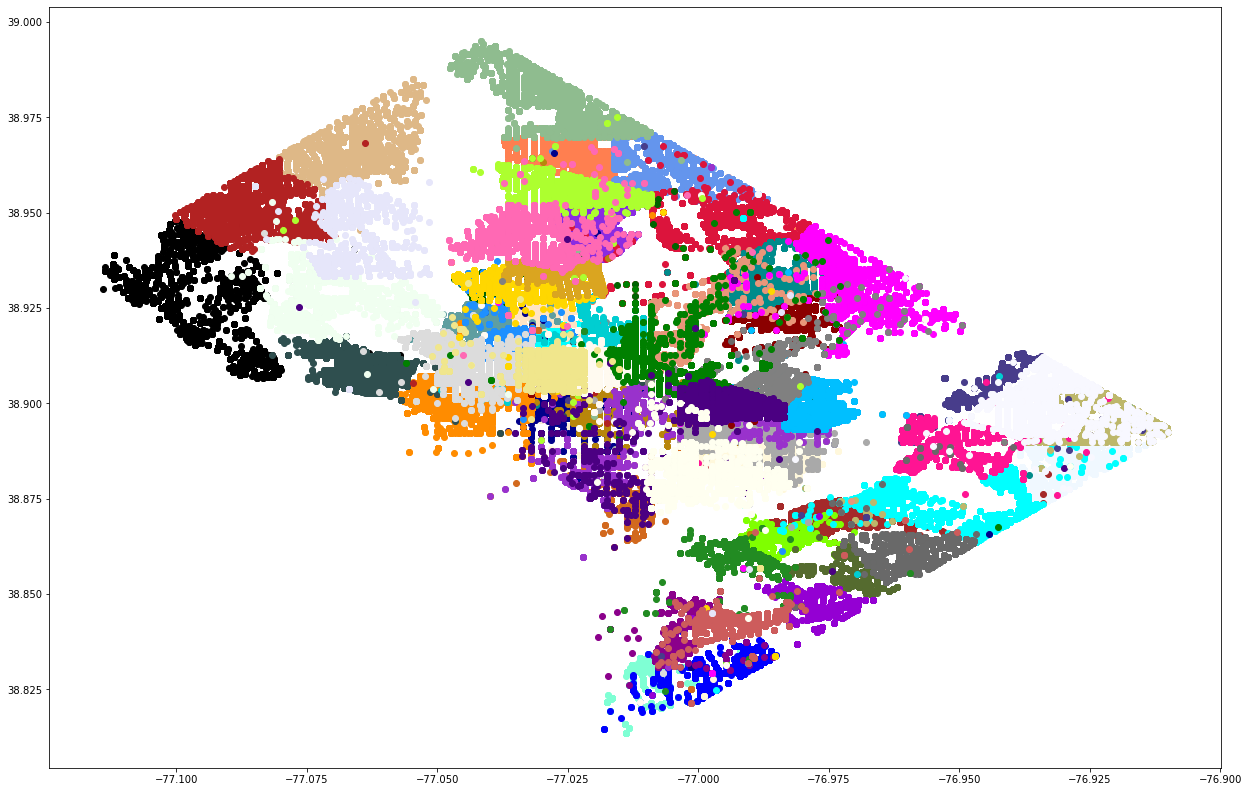

In [36]:
#给予不同PSA的犯罪不同的颜色标识
#可以发现颜色混杂明显，说明PSA这个变量对区域的划分不明确，也可以说PSA这个地理信息错误值较多，不适合用来进行后续分析
crime_by_psa=pd.DataFrame(raw_data2[['LATITUDE','LONGITUDE','PSA']])
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.figure(figsize=(21,14))
for i in range(57):
    crime_psa_i=crime_by_psa[crime_by_psa['PSA']==distinctPSA[i]]
    data1=crime_psa_i['LONGITUDE']
    data2=crime_psa_i['LATITUDE']
    plt.scatter(data1,data2,c=colors[i])
plt.show()

['1D1', '1D2', '1D3', '2D1', '2D2', '2D3', '3D1', '3D2', '3D3', '4D1', '4D2', '4D3', '5D1', '5D2', '5D3', '6D1', '6D2', '6D3', '7D1', '7D2', '7D3']


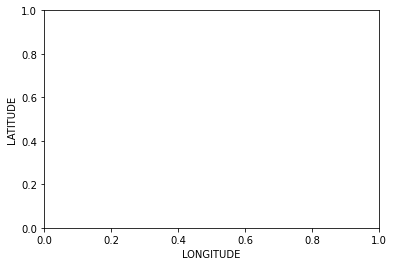

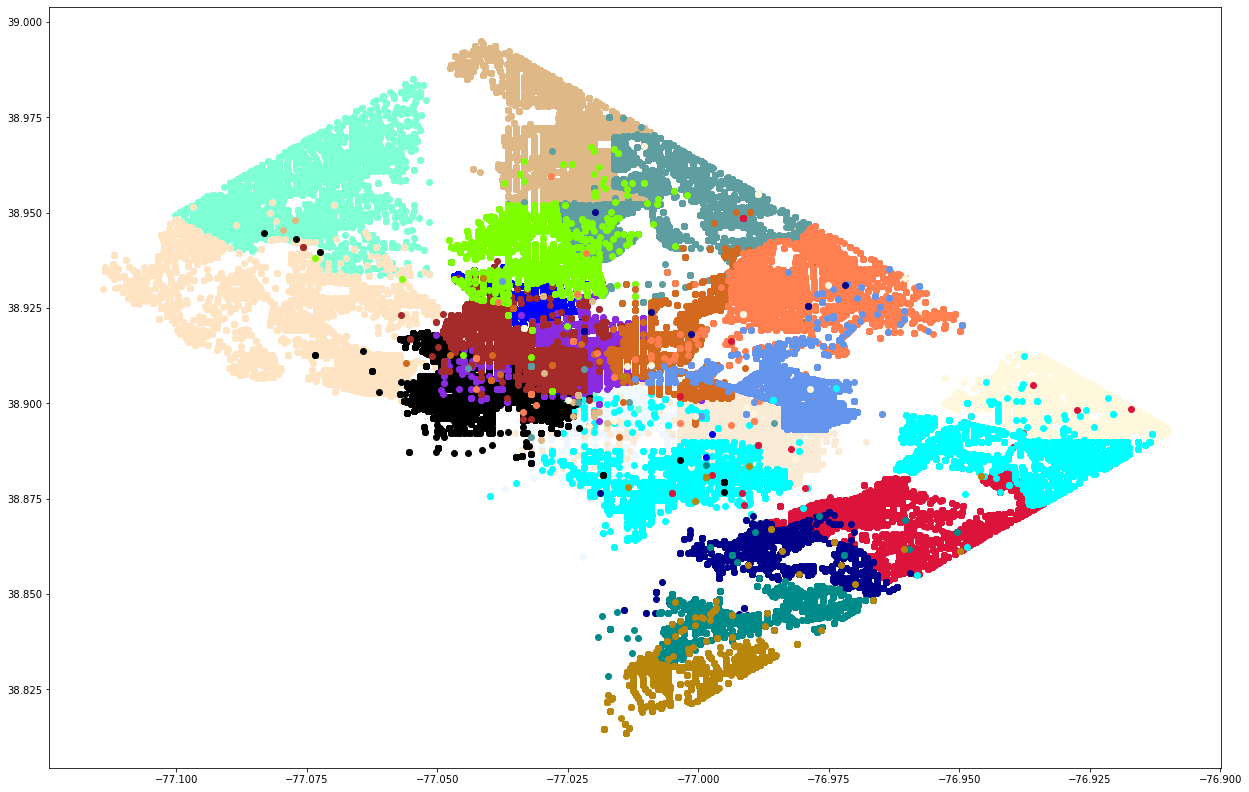

In [37]:
#用不同的颜色标识不同sector的犯罪
#相对于psa,不同sector之间的划分较为明确，而且数量较多，比起ward和district划分更为细致，可以考虑用于后续分析
crime_by_sector=pd.DataFrame(raw_data2[['LATITUDE','LONGITUDE','sector']])
distinctSector=['4D1','1D3','2D1','1D1','2D3','5D2','7D2','2D2','7D3','6D1','4D2','5D1','3D2','1D2','6D3','3D1','5D3','6D2','3D3','7D1','4D3']
distinctSector.sort()
print(distinctSector)
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.figure(figsize=(21,14))
for i in range(21):
    crime_sector_i=crime_by_sector[crime_by_sector['sector']==distinctSector[i]]
    data1=crime_sector_i['LONGITUDE']
    data2=crime_sector_i['LATITUDE']
    plt.scatter(data1,data2,c=colors[i])
plt.show()
#非常浅的蓝，浅玫瑰金，鲜艳的诡异的蓝，鲜艳的诡异的绿，深玫瑰金，黑，蓝，紫色，血红，更深的玫瑰金有点往土黄色靠了，靛，嫩绿，橙，粉+金
#天蓝，非常非常浅的金黄，花红，鲜艳的诡异的蓝，深蓝，深绿，金黄

In [38]:
###Task2 结论
#根据district或者ward 或者sector进行分类，发现是day 和evening的 犯罪数量最多
# offence 和method 有较大的关系和相关性
#观察每个时间段发生的次数，在midnight时offence的次数相对较少一些
#可以发现不同ward间界限较为明确，但区域较大，划分过于粗糙
#根据时间信息划分，月份2月到5月时期的犯罪数量较少
##给予不同PSA的犯罪不同的颜色标识
#可以发现颜色混杂明显，说明PSA这个变量对区域的划分不明确，也可以说PSA这个地理信息错误值较多，不适合用来进行后续分析
##用不同颜色标出不同district的犯罪
#可以发现district之间界限明确，但区域较大，划分过于粗糙
##用不同的颜色标识不同sector的犯罪
#相对于psa,不同sector之间的划分较为明确，而且数量较多，比起ward和district划分更为细致，可以考虑用于后续分析等等
#等等其他操作详情请见Task2分析代码

In [39]:
###Task3-Part1###
#这里将介绍我们使用的第一种聚类方法——KMeans
#使用KMeans的理由：
#1.原理比较简单，实现也是很容易，收敛速度快
#2.算法的可解释度比较强
#3.主要需要调参的参数仅仅是簇数k

In [40]:
#one -hot 编码作案手段
OFFENSE_dummies=pd.get_dummies(raw_data["OFFENSE"],prefix="OFFENSE")
OFFENSE_dummies.head(10)
raw_data=pd.concat([raw_data,OFFENSE_dummies],axis=1)
print(raw_data)

        METHOD              OFFENSE NEIGHBORHOOD_CLUSTER  CENSUS_TRACT  \
0       others         theft f/auto           cluster 21        8702.0   
1       others         theft f/auto           cluster 16        1600.0   
2       others          theft/other            cluster 8        4702.0   
3       others          theft/other           cluster 31        7808.0   
4       others          theft/other           cluster 39       10900.0   
...        ...                  ...                  ...           ...   
448413  others          theft/other           cluster 22       11100.0   
448414  others  motor vehicle theft            cluster 6        5201.0   
448415  others          theft/other           cluster 23        8802.0   
448416  others  motor vehicle theft           cluster 23        8802.0   
448417  others         theft f/auto            cluster 3        3400.0   

          XBLOCK                                         BLOCK    YBLOCK  \
0       399690.0                150

In [41]:

data_xblock_count=pd.DataFrame(raw_data[['XBLOCK','OFFENSE']])
data_xblock_count=pd.DataFrame(data_xblock_count.groupby(['XBLOCK'],as_index=False)['OFFENSE'].size())
#data_xblock_count['XBLOCK']=data_xblock_count['XBLOCK'].astype(int)
# data_xblock_count['YBLOCK']=data_xblock_count['YBLOCK'].astype(int)
data_xblock_count

,XBLOCK,size
0,390103.0,1
1,390147.0,6
2,390151.0,1
3,390224.0,1
4,390262.0,14
...,...,...
7638,407727.0,82
7639,407736.0,18
7640,407760.0,1
7641,407795.0,22


0.6838050250369521
2


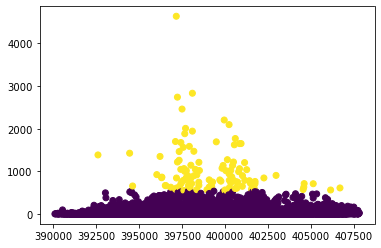

        XBLOCK  size  y_pred
0     390103.0     1       0
1     390147.0     6       0
2     390151.0     1       0
3     390224.0     1       0
4     390262.0    14       0
...        ...   ...     ...
7638  407727.0    82       0
7639  407736.0    18       0
7640  407760.0     1       0
7641  407795.0    22       0
7642  407806.0    21       0

[7643 rows x 3 columns]


In [42]:

from sklearn import metrics
data_show_julei=pd.DataFrame(raw_data[['LATITUDE','LONGITUDE','XBLOCK']])
data_show_julei['flag']=0
from sklearn.cluster import KMeans
score=0
cluster_temp=0
for i in range(2,10):
    kmeans=KMeans(n_clusters=i,random_state=9)
# y_pred = kmeans.fit_predict( data_xblock_count.values[:,1].reshape(-1,1))
    y_pred = kmeans.fit_predict(data_xblock_count.values[:,1].reshape(-1,1))
    a=metrics.silhouette_score(data_xblock_count.values[:,1].reshape(-1,1), y_pred)
    if a >score:
        score=a
        cluster_temp=i

print(a)
print(cluster_temp)
#所以结果最好是分成两类 
# plt.scatter(data_xblock_count.values[:,0], data_xblock_count.values[:,1], c=y_pred)
# plt.show()
from sklearn import metrics
from sklearn.cluster import KMeans
kmeans=KMeans(n_clusters=cluster_temp,random_state=9)
y_pred = kmeans.fit_predict(data_xblock_count.values[:,1].reshape(-1,1))
plt.scatter(data_xblock_count.values[:,0], data_xblock_count.values[:,1], c=y_pred)
plt.show()

data_xblock_count['y_pred']=y_pred
print(data_xblock_count)

# res0Series = pd.Series(kmeans.labels_)
# res0 = res0Series[res0Series.values == 0]
# result_0=data_xblock_count.iloc[res0.index]
# result_0.reset_index(inplace=True,drop=True)
# print("类别为0的数据\n",(data_xblock_count.iloc[res0.index]))

# res1Series = pd.Series(kmeans.labels_)
# res1 = res1Series[res1Series.values == 1]
# result_1=data_xblock_count.iloc[res1.index]
# result_1.reset_index(inplace=True,drop=True)
# print("类别为1的数据\n",(data_xblock_count.iloc[res1.index]))

# res2Series = pd.Series(kmeans.labels_)
# res2 = res2Series[res2Series.values == 2]
# result_2=data_xblock_count.iloc[res2.index]
# result_2.reset_index(inplace=True,drop=True)
# print("类别为2的数据\n",(data_xblock_count.iloc[res2.index]))

# res3Series = pd.Series(kmeans.labels_)
# res3 = res3Series[res3Series.values == 3]
# result_3=data_xblock_count.iloc[res3.index]
# result_3.reset_index(inplace=True,drop=True)
# print("类别为3的数据\n",(data_xblock_count.iloc[res3.index]))

In [43]:
res0Series = pd.Series(kmeans.labels_)
res0 = res0Series[res0Series.values == 0]
result_0=data_xblock_count.iloc[res0.index]
result_0.reset_index(inplace=True,drop=True)
print("类别为0的数据\n",(data_xblock_count.iloc[res0.index]))

res1Series = pd.Series(kmeans.labels_)
res1 = res1Series[res1Series.values == 1]
result_1=data_xblock_count.iloc[res1.index]
result_1.reset_index(inplace=True,drop=True)
print("类别为1的数据\n",(data_xblock_count.iloc[res1.index]))

# res2Series = pd.Series(kmeans.labels_)
# res2 = res2Series[res2Series.values == 2]
# result_2=data_xblock_count.iloc[res2.index]
# result_2.reset_index(inplace=True,drop=True)
# print("类别为2的数据\n",(data_xblock_count.iloc[res2.index]))

# res3Series = pd.Series(kmeans.labels_)
# res3 = res3Series[res3Series.values == 3]
# result_3=data_xblock_count.iloc[res3.index]
# result_3.reset_index(inplace=True,drop=True)
# print("类别为3的数据\n",(data_xblock_count.iloc[res3.index]))

类别为0的数据
         XBLOCK  size  y_pred
0     390103.0     1       0
1     390147.0     6       0
2     390151.0     1       0
3     390224.0     1       0
4     390262.0    14       0
...        ...   ...     ...
7638  407727.0    82       0
7639  407736.0    18       0
7640  407760.0     1       0
7641  407795.0    22       0
7642  407806.0    21       0

[7530 rows x 3 columns]
类别为1的数据
         XBLOCK  size  y_pred
417   392607.0  1384       1
1213  394449.0  1425       1
1300  394622.0   656       1
1895  396029.0   923       1
1990  396217.0  1349       1
...        ...   ...     ...
6749  404579.0   630       1
6752  404600.0   712       1
6904  405127.0   709       1
7299  406139.0   562       1
7492  406683.0   610       1

[113 rows x 3 columns]


In [44]:
# 0 是很少， 1 是最多， 2是第二多， 3是第三多,  如果是分成4类的话
lll=data_xblock_count.shape[0]
for i in range(lll):
    #data_show_julei[data_show_julei['XBLOCK']==data_xblock_count.loc[i,'XBLOCK']]['flag']=data_xblock_count.loc[i,'y_pred']
     data_show_julei.loc[data_show_julei['XBLOCK']==data_xblock_count.loc[i,'XBLOCK'],'flag']=data_xblock_count.loc[i,'y_pred']

In [45]:
data_show_julei

,LATITUDE,LONGITUDE,XBLOCK,flag
0,38.911114,-77.003574,399690.0,0
1,38.982384,-77.026557,397699.0,0
2,38.902518,-77.020913,398186.0,1
3,38.890943,-76.919601,406975.0,0
4,38.822840,-77.003927,399659.0,0
...,...,...,...,...
448413,38.921282,-76.977167,401980.0,0
448414,38.909640,-77.035546,396917.0,0
448415,38.902203,-76.982015,401560.0,1
448416,38.905978,-76.990857,400793.0,0


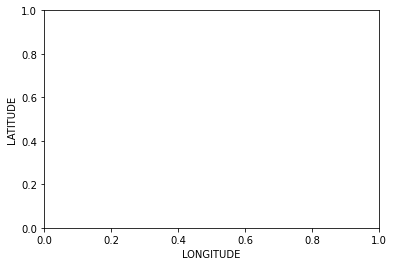

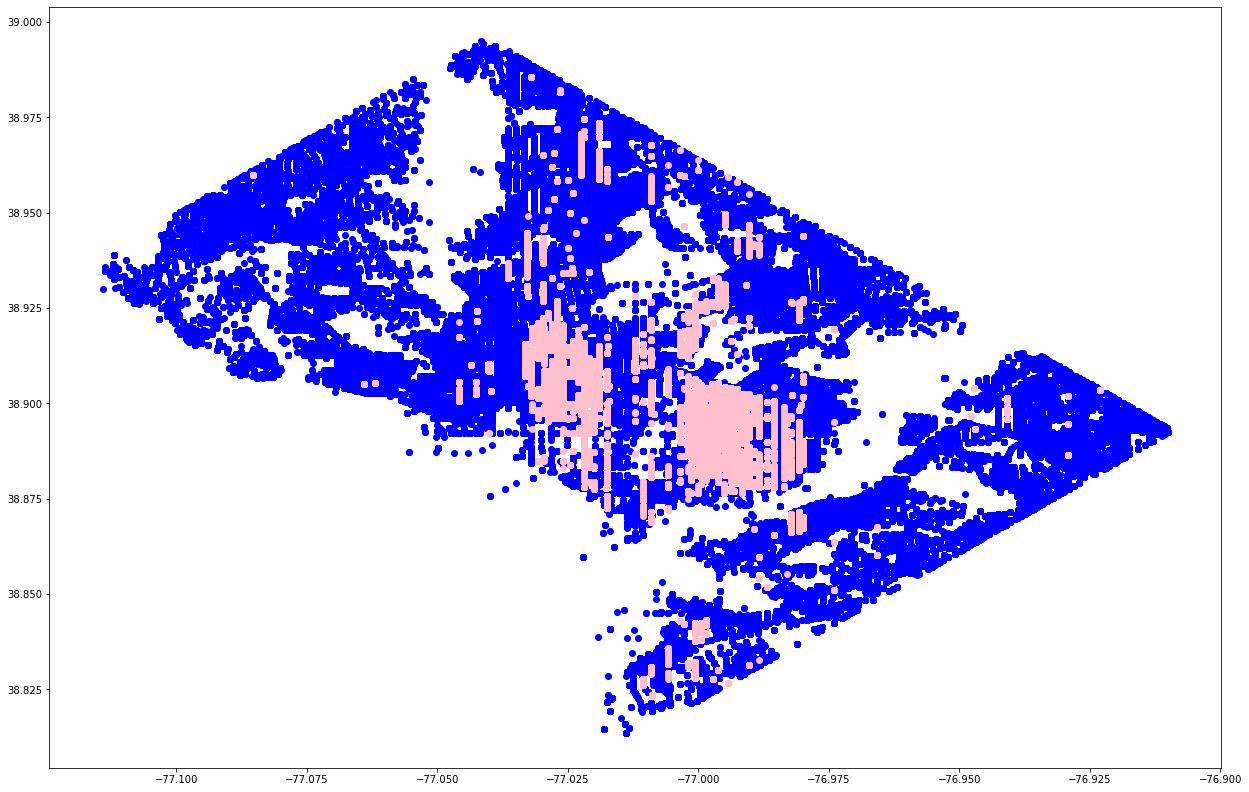

In [46]:
# 0 是犯罪很少  蓝色， 1 是最多  粉色， 2是第二多 绿黄色 ， 3是第三多  红色
# 分成两类的结果：   1 粉色是重灾区，  0是蓝色
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.figure(figsize=(21,14))
#,'#00FF00','#FF0000'
colors=['#0000FF','#FFC0CB']
for i in range(2):
    a=data_show_julei[data_show_julei['flag']==i]
    data1=a['LONGITUDE']
    data2=a['LATITUDE']
    plt.scatter(data1,data2,c=colors[i])
plt.show()
#

In [47]:
#对block 进行预测：

data_block_count=pd.DataFrame(raw_data[['BLOCK','OFFENSE']])
data_block_count=pd.DataFrame(data_block_count.groupby(['BLOCK'],as_index=False)['OFFENSE'].size())
#data_xblock_count['XBLOCK']=data_xblock_count['XBLOCK'].astype(int)
# data_xblock_count['YBLOCK']=data_xblock_count['YBLOCK'].astype(int)
data_block_count
from sklearn import metrics
data_show_block=pd.DataFrame(raw_data[['LATITUDE','LONGITUDE','BLOCK']])
data_show_block['flag']=0

In [48]:

from sklearn.cluster import KMeans
score=0
cluster_temp=0
for i in range(2,10):
    kmeans=KMeans(n_clusters=i,random_state=9)
# y_pred = kmeans.fit_predict( data_xblock_count.values[:,1].reshape(-1,1))
    y_pred = kmeans.fit_predict(data_block_count.values[:,1].reshape(-1,1))
    a=metrics.silhouette_score(data_block_count.values[:,1].reshape(-1,1), y_pred)
    if a >score:
        score=a
        cluster_temp=i

print(a)
print(cluster_temp)
#所以结果最好是分成两类 
# plt.scatter(data_xblock_count.values[:,0], data_xblock_count.values[:,1], c=y_pred)
# plt.show()


0.6866753962529378
2


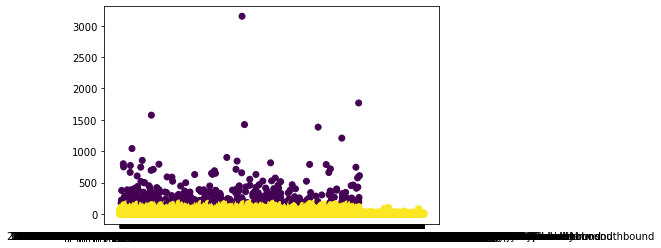

                                             BLOCK  size  y_pred
0                    0 - 0 block of 14th street sw     3       1
1      0 - 0 block of arlington memorial bridge sw     2       1
2                   0 - 0 block of chain bridge nw     1       1
3             0 - 0 block of chevy chase circle nw    13       1
4                0 - 0 block of columbus circle ne    19       1
...                                            ...   ...     ...
17434            yuma street nw and 42nd street nw     1       1
17435             yuma street se and 1st street se     1       1
17436             yuma street se and 8th street se     5       1
17437             yuma street se and 9th street se     3       1
17438         yuma street se and condon terrace se     1       1

[17439 rows x 3 columns]


In [49]:
kmeans=KMeans(n_clusters=cluster_temp,random_state=9)
y_pred = kmeans.fit_predict(data_block_count.values[:,1].reshape(-1,1))
plt.scatter(data_block_count.values[:,0], data_block_count.values[:,1], c=y_pred)
plt.show()

data_block_count['y_pred']=y_pred
print(data_block_count)

In [50]:
###Task3-Part1###
#之所以选择xblock进行聚类，是因为xblock的类别数比较多，这样方便聚类来减少类别数。然后将聚类的结果画在经纬度的图中。效果较好
#再选择block 进行Kmeans聚类。从图中可以看出聚类的效果欠佳，需要改进。
#

In [51]:
###Task3-Part2###
#这里将介绍我们使用的第二种聚类方法——ChiMerge
#使用ChiMerge的理由：
#1.根据犯罪数量的聚类可能导致不相邻的区域聚到同一类去，这就有些不合理，ChiMerge只会将相邻的区域进行合并
#2.犯罪数量只是犯罪的其中一个特征，用ChiMerge将区域进行合并能考虑到各个类型犯罪在各个区域的占比，将占比相似的区域进行合并
#ChiMerge的更多说明：
#1.我们对sector地理信息进行合并，将相似的sector合并起来
#2.不同sector之间是否相邻是通过可视化结果判断的，通过可视化结果写出sector之间的邻接矩阵
#3.由于使用python实现ChiMerge有一定难度，速度也较慢，因此使用C++,提交代码中的main.cpp即为ChiMerge程序
#局限性：我们设置最终得到的新聚类为4类，没有尝试采用为卡方设置threshold的方式进行测试

In [52]:
#将ChiMerge聚类结果与crime_data结合
#列表mappedID即是ChiMerge聚类结果，代表各个sector经过ChiMerge后所在的新聚类ID
#给予每个犯罪信息一个ClusterID，这个ClusterID就是聚类后的各个聚类的ID
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
distinctSector=['4D1','1D3','2D1','1D1','2D3','5D2','7D2','2D2','7D3','6D1','4D2','5D1','3D2','1D2','6D3','3D1','5D3','6D2','3D3','7D1','4D3']
distinctSector.sort()
raw_data=pd.read_csv("DC_Crime.csv")
mappedID=[0,0,0,1,1,1,0,0,0,2,2,2,2,2,2,3,3,3,3,3,3]
df=pd.DataFrame()
df['sector']=distinctSector
df['ClusterID']=mappedID
sectorCluster=raw_data[['LONGITUDE','LATITUDE','sector']]
sectorCluster['ClusterID']=0
lll=df.shape[0]
for i in range(lll):
    sectorCluster.loc[sectorCluster['sector']==df.loc[i,'sector'],'ClusterID']=df.loc[i,'ClusterID']

<ipython-input-52-2717482b62f9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sectorCluster['ClusterID']=0
C:\Users\admin\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


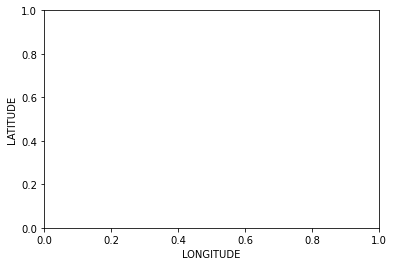

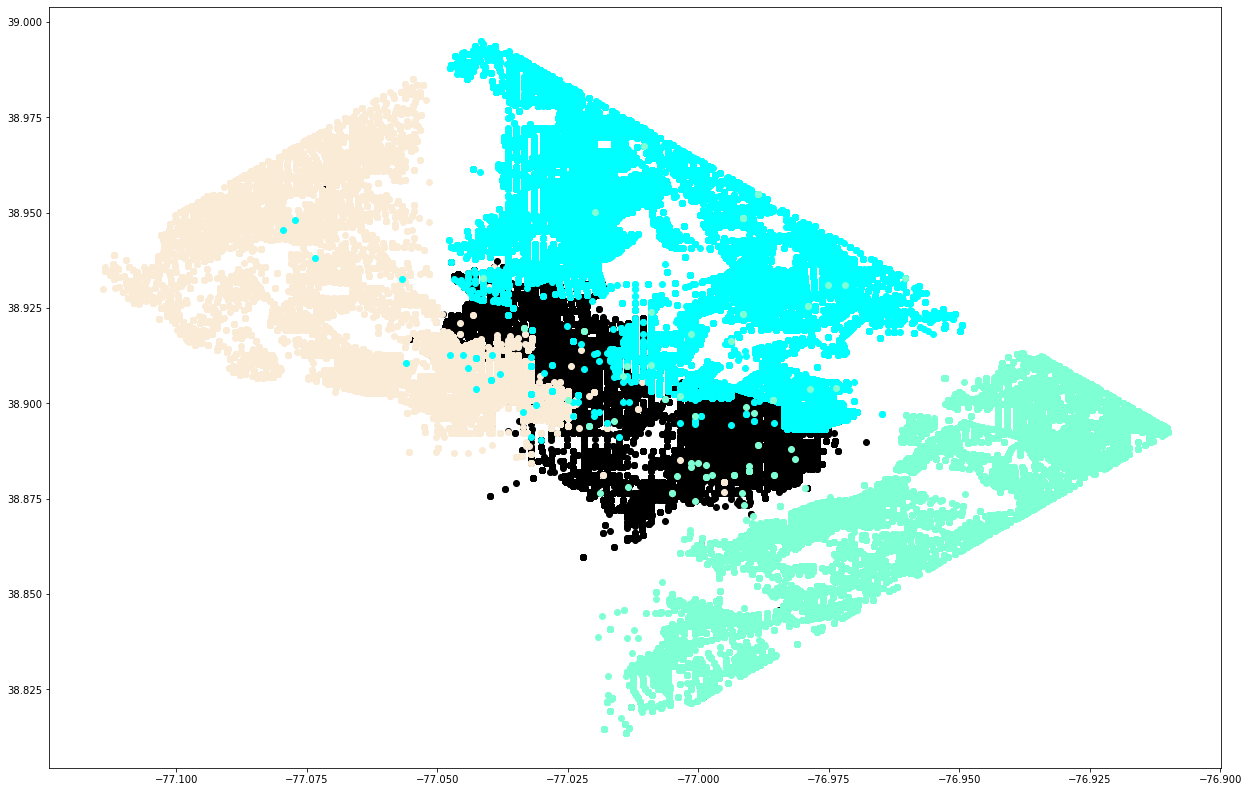

In [53]:
#将ChiMerge结果进行可视化
%matplotlib inline
crime_by_sectorCluster=pd.DataFrame(sectorCluster[['LATITUDE','LONGITUDE','ClusterID']])
colors=['#000000','#FAEBD7','#00FFFF','#7FFFD4']
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.figure(figsize=(21,14))
for i in range(4):
    crime_psa_i=crime_by_sectorCluster[crime_by_sectorCluster['ClusterID']==i]
    data1=crime_psa_i['LONGITUDE']
    data2=crime_psa_i['LATITUDE']
    plt.scatter(data1,data2,c=colors[i])
plt.show()

In [54]:
#Task3的小结
#在Task3中，我们分别使用了kmeans和ChiMerge两种聚类方式对犯罪的地理信息进行聚类
#从可视化中，我么可以看到两种聚类的效果有相似之处（第一种方式中得到的粉色部分和第二种方式中得到的黑色部分有较高重合度）
##

In [55]:
####Task4####
##在Task4中，我们的主要任务是使用回归模型对房价进行预测
##

In [56]:
#导入property的数据集
DC_property=pd.read_csv("DC_Properties.csv",index_col=0)

C:\Users\admin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19,20,21,22,23,24,33,34,35,37,43,45) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [57]:
#很多缺失值，所以drop
myData=DC_property.drop(columns=['LIVING_GBA','CMPLX_NUM'],axis=1)

In [58]:
#categorical type, 用众数填补
myData.NUM_UNITS=myData.NUM_UNITS.fillna(myData.NUM_UNITS.mode()[0])

In [59]:
#过多缺失值，所以drop
myData.drop(columns=['YR_RMDL'],axis=1,inplace=True)

In [60]:
#categorical type,用众数填补
myData.STORIES=myData.STORIES.fillna(myData.STORIES.mode()[0])
myData.SALEDATE=myData.SALEDATE.fillna(myData.SALEDATE.mode()[0])

In [61]:
#numeric type,用中位数填补 (不用均值是为了避免outlier的影响和the skewness of distribution的影响)
myData.GBA=myData.GBA.fillna(myData.GBA.median())

In [62]:
#numeric type,用中位数填补
myData.KITCHENS=myData.KITCHENS.fillna(myData.KITCHENS.median())

In [63]:
#categorical type, 用众数填补
myData.STRUCT=myData.STRUCT.fillna(myData.STRUCT.mode()[0])
myData.STYLE=myData.STYLE.fillna(myData.STYLE.mode()[0])
myData.GRADE=myData.GRADE.fillna(myData.GRADE.mode()[0])
myData.CNDTN=myData.CNDTN.fillna(myData.CNDTN.mode()[0])
myData.EXTWALL=myData.EXTWALL.fillna(myData.EXTWALL.mode()[0])
myData.ROOF=myData.ROOF.fillna(myData.ROOF.mode()[0])
myData.INTWALL=myData.INTWALL.fillna(myData.INTWALL.mode()[0])
myData.FULLADDRESS=myData.FULLADDRESS.fillna(myData.FULLADDRESS.mode()[0])
myData.CENSUS_BLOCK=myData.CENSUS_BLOCK.fillna(myData.CENSUS_BLOCK.mode()[0])

In [64]:
#将X中缺失值去除，因为其中有一些记录的SQUARE属性异常
#删去这些缺失值后，SQAURE属性可以直接转为numeric type
myData=myData.dropna(subset=['X'],axis=0)

In [65]:
#去除重复的列，比如X和Y就和经纬度重复
myData.drop(columns=['X','Y'],axis=1,inplace=True)
myData.drop(columns=['CITY','STATE','NATIONALGRID'],axis=1,inplace=True)

In [66]:
#categorical type,众数填补
myData.ASSESSMENT_SUBNBHD=myData.ASSESSMENT_SUBNBHD.fillna(myData.ASSESSMENT_SUBNBHD.mode()[0])

In [67]:
#numeric type,中位数填补
myData.AYB=myData.AYB.fillna(myData.AYB.median())

In [68]:
#舍弃不合理的值
myData=myData[myData['PRICE']>0]

In [69]:
#用LabelEncoder将object type的属性转为numeric type
#为了能使用RandomForestRegressor的必要步骤
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
myData['HEAT']=lb.fit_transform(myData['HEAT'])
myData['AC']=lb.fit_transform(myData['AC'])
myData['QUALIFIED']=lb.fit_transform(myData['QUALIFIED'])
myData['STYLE']=lb.fit_transform(myData['STYLE'])
myData['STRUCT']=lb.fit_transform(myData['STRUCT'])
myData['GRADE']=lb.fit_transform(myData['GRADE'])
myData['CNDTN']=lb.fit_transform(myData['CNDTN'])
myData['EXTWALL']=lb.fit_transform(myData['EXTWALL'])
myData['ROOF']=lb.fit_transform(myData['ROOF'])
myData['INTWALL']=lb.fit_transform(myData['INTWALL'])
myData.drop(columns=['GIS_LAST_MOD_DTTM'],inplace=True)
myData['SOURCE']=lb.fit_transform(myData['SOURCE'])
myData['FULLADDRESS']=lb.fit_transform(myData['FULLADDRESS'])
myData['QUADRANT']=lb.fit_transform(myData['QUADRANT'])
myData['WARD']=lb.fit_transform(myData['WARD'])
myData['ASSESSMENT_NBHD']=lb.fit_transform(myData['ASSESSMENT_NBHD'])
myData['ASSESSMENT_SUBNBHD']=lb.fit_transform(myData['ASSESSMENT_SUBNBHD'])

In [70]:
#改变SALEDATE属性，只保留year属性
myData['SALEDATE']=pd.to_datetime(myData['SALEDATE'], format="%Y/%m/%d")
myData['SALEDATE']= myData['SALEDATE'].dt.year

In [71]:
#将SQUARE属性转为numeric type
myData['SQUARE']=myData['SQUARE'].astype('int32')

In [72]:
#舍弃Outlier
#threshold 150 来自于可视化的结果
myData=myData[myData['FIREPLACES']<150]

In [73]:
#根据距离该property最近的犯罪确定该property的ClusterID
#ClusterID是Task3新聚类的结果
position=myData[['LATITUDE','LONGITUDE']]
crime_pos=sectorCluster[['LATITUDE','LONGITUDE']]
pos_y=sectorCluster['ClusterID']
from sklearn.neighbors import NearestNeighbors as NN
knn=NN(n_neighbors=1)
knn.fit(crime_pos)
knn_dis,knn_result=knn.kneighbors(position)
knn_result=pd.DataFrame(knn_result)
ll=myData.shape[0]
myData['ClusterID']=-1
for i in range(ll):
    myData.iloc[i,-1]=sectorCluster.iloc[knn_result.iloc[i,0],-1]

In [74]:
#去除不需要的属性
myData=myData.drop(columns=['CENSUS_BLOCK'],axis=1)

In [75]:
#分离自变量和因变量
Y=myData['PRICE']
X=myData.drop(columns=['PRICE'],axis=1)

In [76]:
#分离训练集和测试集
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)

In [77]:
#导入并fit RandomForestRegressor
#在看看它在训练集上表现如何
#设置max_depth和min_samples_leaf是为了防止过拟合，如果不加，训练效果会更好，但测试效果会大幅下降
#我们调试了许多值，max_depth=20,min_samples_leaf=30是相对合适的值
from sklearn.ensemble import RandomForestRegressor as RFR
rfr=RFR(max_depth=20,min_samples_leaf=30)
rfr.fit(x_train,y_train)
predict_train_rfr=rfr.predict(x_train)

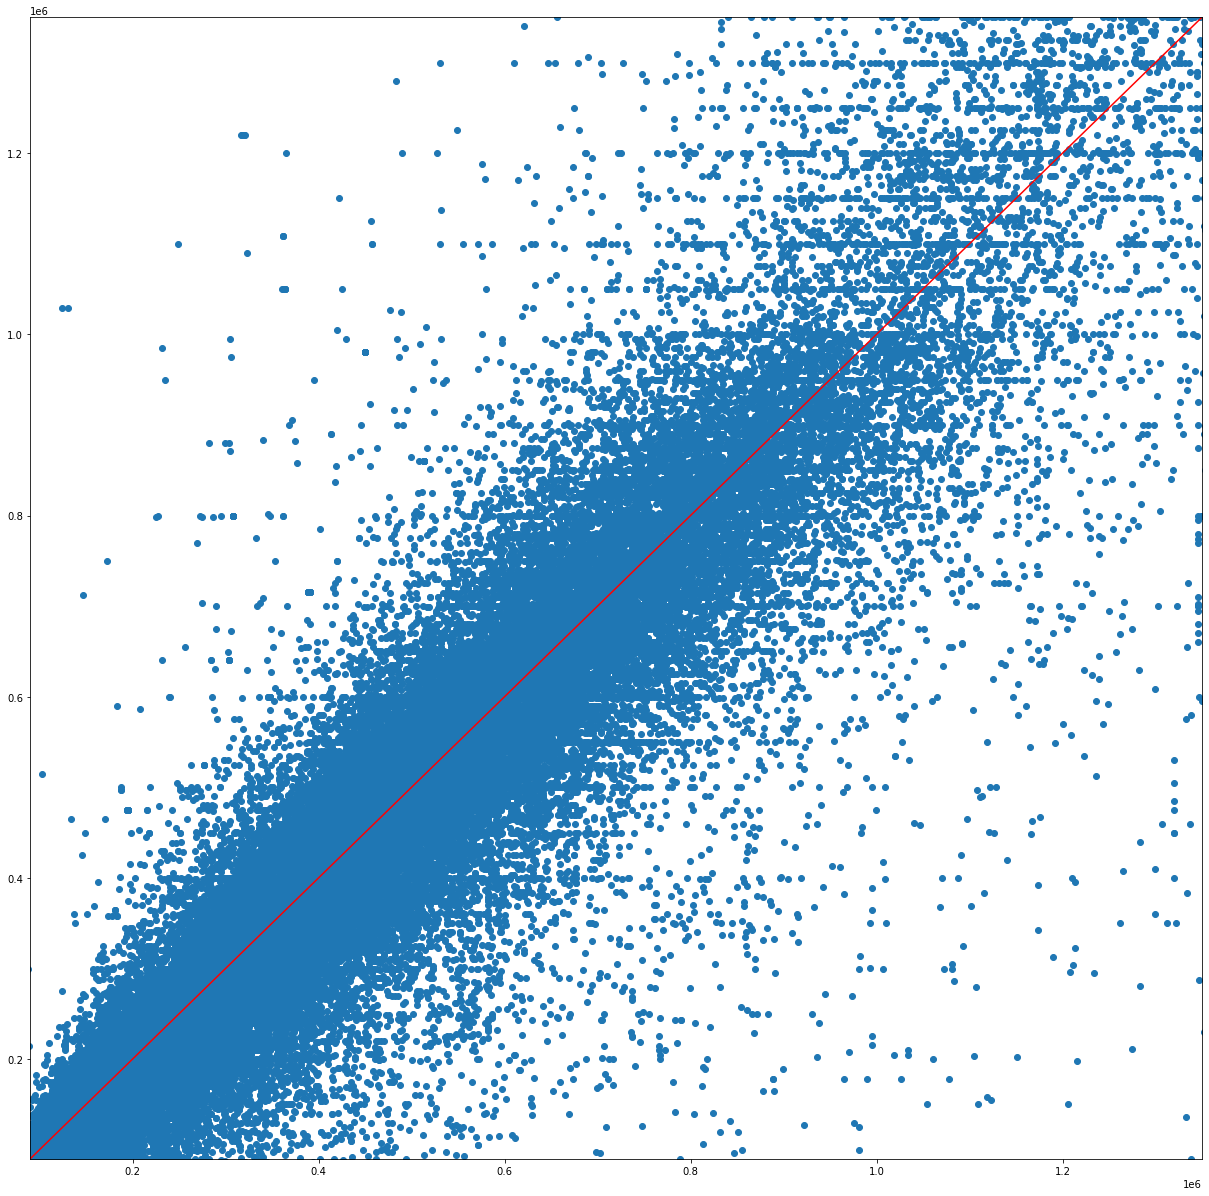

In [78]:
#在训练数据预测结果的可视化
#红色的线代表y=x
#在红线之上意味着预测值要小于实际值
#在红线之下意味着预测值要大于实际值
x_std=np.arange(0,1350000,1)
y_std=x_std
plt.figure(figsize=(21,21))
plt.scatter(predict_train_rfr,y_train)
plt.plot(x_std,y_std,color='#FF0000')
plt.ylim(90000,1350000)
plt.xlim(90000,1350000)
plt.show()

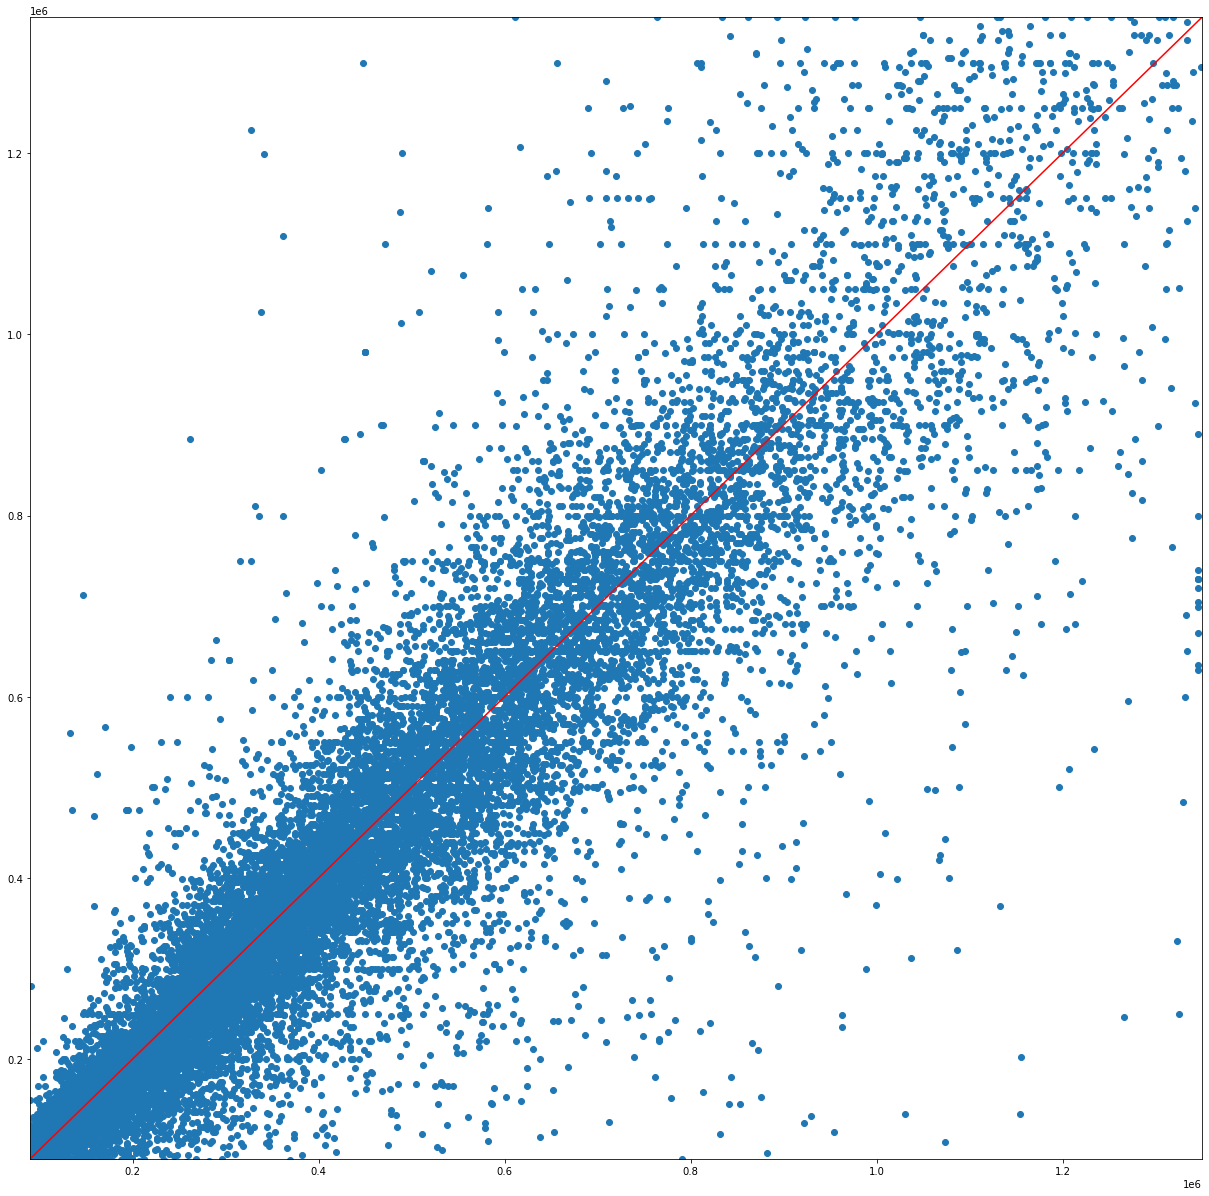

In [79]:
#在测试数据集上预测并可视化
predict_test_rfr=rfr.predict(x_test)
x_std=np.arange(0,1350000,1)
y_std=x_std
plt.figure(figsize=(21,21))
plt.scatter(predict_test_rfr,y_test)
plt.plot(x_std,y_std,color='#FF0000')
plt.ylim(90000,1350000)
plt.xlim(90000,1350000)
plt.show()

In [80]:
#计算在测试集上的r2_score
#r2_score能达到0.95左右，说明回归效果相当不错
from sklearn.metrics import r2_score
r2_score(y_test,predict_test_rfr)

0.9465926764570896

In [81]:
#计算在训练集上的r2_score
#发现在训练集上的r2_score和测试集上的r2_score差别不大，说明过拟合不明显
r2_score(y_train,predict_train_rfr)

0.9220824780692547

In [82]:
#准备看看各个属性对房价的影响程度
df_x=pd.DataFrame(X)
df_x.columns.values

array(['BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS', 'ROOMS', 'BEDRM',
       'AYB', 'EYB', 'STORIES', 'SALEDATE', 'QUALIFIED', 'SALE_NUM',
       'GBA', 'BLDG_NUM', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN', 'EXTWALL',
       'ROOF', 'INTWALL', 'KITCHENS', 'FIREPLACES', 'USECODE', 'LANDAREA',
       'SOURCE', 'FULLADDRESS', 'ZIPCODE', 'LATITUDE', 'LONGITUDE',
       'ASSESSMENT_NBHD', 'ASSESSMENT_SUBNBHD', 'CENSUS_TRACT', 'WARD',
       'SQUARE', 'QUADRANT', 'ClusterID'], dtype=object)

In [83]:
#得到重要程度
importance=pd.DataFrame()
importance['name']=df_x.columns.values
importance['value']=rfr.feature_importances_

In [84]:
#对重要程度进行排序
importance.sort_values(by=['value'])

,name,value
14,BLDG_NUM,0.000000e+00
36,QUADRANT,8.120257e-08
4,NUM_UNITS,1.396068e-07
21,INTWALL,1.996733e-07
3,AC,2.896478e-07
15,STYLE,4.538067e-07
22,KITCHENS,4.734700e-07
9,STORIES,5.094032e-07
19,EXTWALL,5.705423e-07
16,STRUCT,1.345909e-06


In [85]:
#Task4的小结
#在Task4中，我们使用了RandomForestRegressor模型来对房价进行拟合
#通过房价的预测，我们发现在Task3中聚类结果是对房价预测有正面作用的，从侧面说明了Task3中聚类效果良好
#优点：房价拟合效果较好，预测误差较小
#局限性：由于RandomForestRegressor的局限性，难以实现对未来房价的预测
#可能的改进方案：也许可以通过RNN或LSTM的神经网络的方法对时间序列进行更好的分析，对未来房价进行预测
#其它结论：通过RandomForestRegressor的Feature_importances_变量，可以查看各个属性对回归模型的贡献程度
#发现经度，是否qualified, heat的方式，Census_tract（地理位置），土地面积，销售时间等因素为影响房价的最主要因素

In [86]:
###Task5###
#对不同census_tract地域的犯罪量和犯罪种类，以及当地房价进行相关性的探究
#
import pandas as pd
crime_data=pd.read_csv("DC_crime.csv")
crime_data

,NEIGHBORHOOD_CLUSTER,CENSUS_TRACT,offensegroup,LONGITUDE,END_DATE,offense-text,SHIFT,YBLOCK,DISTRICT,WARD,...,BLOCK,START_DATE,CCN,OFFENSE,OCTO_RECORD_ID,ANC,REPORT_DAT,METHOD,location,LATITUDE
0,cluster 21,8702.0,property,-77.003574,2017-04-29T08:00:23.000,theft f/auto,day,138139.0,5.0,5.0,...,150 - 299 block of q street ne,2017-04-29T01:30:14.000,17070672,theft f/auto,17070672-01,5E,2017-04-29T13:49:31.000Z,others,"38.911121322949178,-77.003576581965632",38.911114
1,cluster 16,1600.0,property,-77.026557,2017-04-29T08:30:37.000,theft f/auto,day,146051.0,4.0,4.0,...,7600 - 7699 block of georgia avenue nw,2017-04-29T02:30:10.000,17070675,theft f/auto,17070675-01,4A,2017-04-29T14:38:59.000Z,others,"38.982391883146363,-77.026559339798794",38.982384
2,cluster 8,4702.0,property,-77.020913,2017-04-29T11:10:57.000,theft/other,day,137185.0,1.0,6.0,...,600 - 699 block of k street nw,2017-04-29T10:43:33.000,17070714,theft/other,17070714-01,6E,2017-04-29T15:19:02.000Z,others,"38.902525540064957,-77.020915170313728",38.902518
3,cluster 31,7808.0,property,-76.919601,2017-04-28T09:30:33.000,theft/other,day,135903.0,6.0,7.0,...,5715 5739 block of blaine street ne,2017-04-28T09:15:27.000,17070736,theft/other,17070736-01,7C,2017-04-29T16:11:44.000Z,others,"38.890951021927407,-76.919603310082607",38.890943
4,cluster 39,10900.0,property,-77.003927,2017-04-29T13:42:11.000,theft/other,day,128340.0,7.0,8.0,...,4610 - 4659 block of south capitol street,2017-04-29T13:03:40.000,17070780,theft/other,17070780-01,8D,2017-04-29T18:17:15.000Z,others,"38.822847890448664,-77.003929146312586",38.822840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449198,cluster 22,11100.0,property,-76.977167,2021-03-17T20:20:07.000,theft/other,evening,139268.0,5.0,5.0,...,1815 - 1999 block of bryant street ne,2021-03-17T20:15:08.000,21034375,theft/other,21034375-01,5C,2021-03-17T21:07:30.000,others,"38.9212817635688,-76.9771673661107",38.921282
449199,cluster 6,5201.0,property,-77.035546,2021-03-17T17:20:33.000,motor vehicle theft,evening,137976.0,2.0,2.0,...,1500 - 1599 block of p street nw,2021-03-16T21:00:41.000,21034386,motor vehicle theft,21034386-01,2B,2021-03-17T21:38:51.000,others,"38.9096398205834,-77.0355462229667",38.909640
449200,cluster 23,8802.0,property,-76.982015,2021-03-17T23:09:20.000,theft/other,midnight,137150.0,5.0,5.0,...,900 - 999 block of bladensburg road ne,2021-03-17T22:21:45.000,21034407,theft/other,21034407-01,5D,2021-03-18T01:12:46.000,others,"38.9022029472732,-76.9820154636605",38.902203
449201,cluster 23,8802.0,property,-76.990857,2021-03-17T22:40:24.000,motor vehicle theft,midnight,137569.0,5.0,5.0,...,1300 - 1399 block of west virginia avenue ne,2021-03-17T22:38:11.000,21034425,motor vehicle theft,21034425-01,5D,2021-03-18T00:57:07.000,others,"38.905978473251,-76.9908573768314",38.905978


In [87]:
crime_data.isnull().sum()
#删除缺失行过多的列
crime_data.drop(columns=['BID','START_DATE','END_DATE'],inplace=True)
crime_data['REPORT_DAT']

0         2017-04-29T13:49:31.000Z
1         2017-04-29T14:38:59.000Z
2         2017-04-29T15:19:02.000Z
3         2017-04-29T16:11:44.000Z
4         2017-04-29T18:17:15.000Z
                    ...           
449198     2021-03-17T21:07:30.000
449199     2021-03-17T21:38:51.000
449200     2021-03-18T01:12:46.000
449201     2021-03-18T00:57:07.000
449202     2021-03-25T14:41:36.000
Name: REPORT_DAT, Length: 449203, dtype: object

In [88]:
# REPORT_DAT转为datetime类型分成year列和month列，方便处理
crime_data['REPORT_DAT']=pd.to_datetime(crime_data['REPORT_DAT'],utc=True)
crime_data['year']=crime_data['REPORT_DAT'].dt.year
crime_data['month']=crime_data['REPORT_DAT'].dt.month
#去除REPORT_DAT列
crime_data.drop(columns=['REPORT_DAT'],inplace=True)

In [89]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449203 entries, 0 to 449202
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   NEIGHBORHOOD_CLUSTER  443701 non-null  object 
 1   CENSUS_TRACT          448011 non-null  float64
 2   offensegroup          449203 non-null  object 
 3   LONGITUDE             449203 non-null  float64
 4   offense-text          449203 non-null  object 
 5   SHIFT                 449203 non-null  object 
 6   YBLOCK                449203 non-null  float64
 7   DISTRICT              448991 non-null  float64
 8   WARD                  449192 non-null  float64
 9   YEAR                  449203 non-null  int64  
 10  offensekey            449203 non-null  object 
 11  sector                448960 non-null  object 
 12  PSA                   448960 non-null  float64
 13  ucr-rank              449203 non-null  int64  
 14  BLOCK_GROUP           448011 non-null  object 
 15  

In [90]:
crime_data.dropna(subset=['CENSUS_TRACT','OFFENSE','offensegroup'],axis=0,inplace=True)
# 观察  不同的犯罪数量
num_case_ct=crime_data.groupby(['CENSUS_TRACT']).count()[['offensegroup']]
num_case_ct

,offensegroup
CENSUS_TRACT,
100.0,5338
201.0,545
202.0,6602
300.0,1734
400.0,721
...,...
10700.0,10602
10800.0,2939
10900.0,2508


In [91]:
raw_data=pd.read_csv("DC_properties.csv",index_col=0)

C:\Users\admin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19,20,21,22,23,24,33,34,35,37,43,45) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [92]:
# 计算不同census _tract 的median 
median_price=pd.DataFrame(raw_data.groupby(['CENSUS_TRACT']).median()['PRICE'])
median_price

,PRICE
CENSUS_TRACT,
100.0,874500.0
202.0,841000.0
300.0,667000.0
400.0,911340.0
501.0,445350.0
...,...
10700.0,372000.0
10800.0,200000.0
10900.0,85000.0


In [93]:
#显示不同的地区的犯罪数量以及当地的房价
myData=num_case_ct.join(median_price,how='outer')
myData

,offensegroup,PRICE
CENSUS_TRACT,,
100.0,5338,874500.0
201.0,545,NaN
202.0,6602,841000.0
300.0,1734,667000.0
400.0,721,911340.0
...,...,...
10700.0,10602,372000.0
10800.0,2939,200000.0
10900.0,2508,85000.0


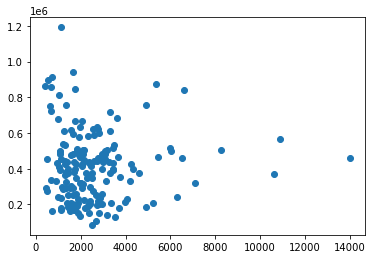

In [94]:
%matplotlib inline
import matplotlib.pyplot as plt
#将犯罪数量和房子价格可视化
plt.scatter(myData['offensegroup'],myData['PRICE'])
plt.show()

In [95]:
#协方差观察相关性
#犯罪数量和房子价格的相关性较低
myData.corr()

,offensegroup,PRICE
offensegroup,1.000000,0.010648
PRICE,0.010648,1.000000


In [96]:
#将犯罪类型为钱的property 划分出来
property_crime=crime_data[crime_data['offensegroup']=='property']

In [97]:
#为钱的犯罪数量生成出来为property_count
property_count=pd.DataFrame(property_crime.groupby(['CENSUS_TRACT']).count()[['offensegroup']])
property_count

,offensegroup
CENSUS_TRACT,
100.0,5055
201.0,517
202.0,6269
300.0,1640
400.0,696
...,...
10700.0,9801
10800.0,2740
10900.0,1911


In [98]:
#计算不同的犯罪类型和census_tract的相关性，
for i in ['theft/other','sex abuse','motor vehicle theft','arson','robbery','theft f/auto','homicide','burglary','assault w/dangerous weapon']:
    property_offense1=crime_data[(crime_data['OFFENSE']==i)]
    property_offense1=pd.DataFrame(property_offense1.groupby(['CENSUS_TRACT']).count()[['offensegroup']])
    #print(property_offense1)
    print(i)
    myData=property_offense1.join(median_price,how='outer')
    #print(myData)
    #plt.scatter(myData['offensegroup'],myData['PRICE'])
    #plt.show()
    print(myData.corr())
#  motor vehicle theft和 price 的负相关性较高，达到 -0.47
#homicide 和price 的负相关性较高，达到-0.598
#assault w/dangerous weapon也和price 的负相关性较高，达到-0.599

#所以可以得出结论 ：房子价格越高的地方，电瓶车被偷的数量减少。原因可能是房子价格越高的地方，小区越高档。高档小区人们开法拉利之类的汽车。
#电瓶车的数量减少，所以被偷的数量减少。
#而且房价越高的地方，自杀和枪杀的人越少。我们可以想象房价越高代表越有钱越幸福，烦恼越少，所以自杀和枪杀的人越少。

theft/other
              offensegroup     PRICE
offensegroup      1.000000  0.136704
PRICE             0.136704  1.000000
sex abuse
              offensegroup     PRICE
offensegroup      1.000000 -0.341238
PRICE            -0.341238  1.000000
motor vehicle theft
              offensegroup     PRICE
offensegroup      1.000000 -0.469769
PRICE            -0.469769  1.000000
arson
              offensegroup     PRICE
offensegroup      1.000000 -0.373643
PRICE            -0.373643  1.000000
robbery
              offensegroup     PRICE
offensegroup      1.000000 -0.333624
PRICE            -0.333624  1.000000
theft f/auto
              offensegroup     PRICE
offensegroup      1.000000  0.194804
PRICE             0.194804  1.000000
homicide
              offensegroup     PRICE
offensegroup      1.000000 -0.598939
PRICE            -0.598939  1.000000
burglary
              offensegroup     PRICE
offensegroup      1.000000 -0.295229
PRICE            -0.295229  1.000000
assault w/dangerous weapo

In [99]:
myData=property_count.join(median_price,how='outer')
myData

,offensegroup,PRICE
CENSUS_TRACT,,
100.0,5055,874500.0
201.0,517,NaN
202.0,6269,841000.0
300.0,1640,667000.0
400.0,696,911340.0
...,...,...
10700.0,9801,372000.0
10800.0,2740,200000.0
10900.0,1911,85000.0


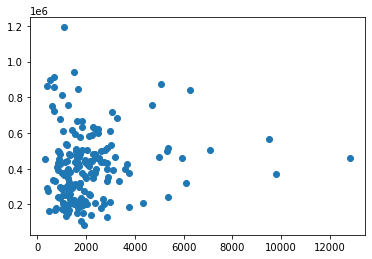

,offensegroup,PRICE
offensegroup,1.000000,0.098683
PRICE,0.098683,1.000000


In [100]:
plt.scatter(myData['offensegroup'],myData['PRICE'])
plt.show()
myData.corr()

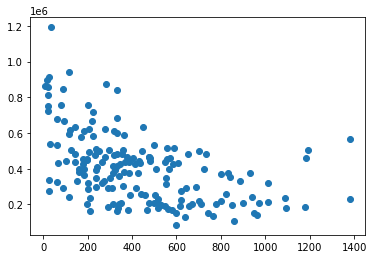

In [101]:
#观察 统计为violent的数据集根据census_tract进行分类和price的相关性
property_crime=crime_data[crime_data['offensegroup']=='violent']
property_count=pd.DataFrame(property_crime.groupby(['CENSUS_TRACT']).count()[['offensegroup']])
myData=property_count.join(median_price,how='outer')
plt.scatter(myData['offensegroup'],myData['PRICE'])
plt.show()

In [102]:
myData.corr()
#可以观察到 房价越高的地方，发生暴力性质的次数在减少。

,offensegroup,PRICE
offensegroup,1.000000,-0.489466
PRICE,-0.489466,1.000000


In [103]:
#根据时间聚合groupby
crime_by_time=crime_data[crime_data['year']<2021].groupby(['year','month']).count()[['offensegroup']]

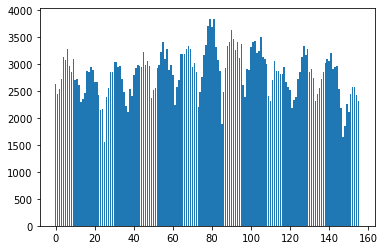

In [104]:
#将数据在不同年份不同月份可视化处理
plt.bar(range(len(crime_by_time['offensegroup'])),crime_by_time['offensegroup'])
plt.show()

In [105]:
#只针对property犯罪类型的数据在不同year，month 时的犯罪次数的计数
property_crime=crime_data[crime_data['offensegroup']=='property']
propertyCrime_by_time=property_crime.groupby(['year','month']).count()[['offensegroup']]

In [106]:
propertyCrime_by_time_new=property_crime.groupby(['year','month'],as_index=False).size()
propertyCrime_by_time_new

,year,month,size
0,2008,1,2071
1,2008,2,1979
2,2008,3,1975
3,2008,4,2076
4,2008,5,2446
...,...,...,...
155,2020,12,2035
156,2021,1,1771
157,2021,2,1487
158,2021,3,1669


In [107]:
propertyMoney_by_time_new=property_crime.groupby(['year','month'],as_index=False).size()

In [108]:
#可能的改进：使用深度学习的RNN或是LSTM模型进行时间序列分析，对未来犯罪数量（尤其是可以看到明确下降趋势的violent类犯罪数量）进行预测

In [109]:
#Task5的结论：
#房子价格越高的地方，电瓶车被偷的数量减少。原因可能是房子价格越高的地方，小区越高档。高档小区人们开法拉利之类的汽车。
#电瓶车的数量减少，所以被偷的数量减少。
#而且房价越高的地方，自杀和枪杀的人越少。我们可以想象房价越高代表越有钱越幸福，烦恼越少，所以自杀和枪杀的人越少。